# Introduction

In this project, we aim at creating a successful recommender engine for TheFork, a leading restaurant app that helps users find and make reservations in restaurants. Obviously, at the core of their business model is a powerful recommender system that provided personalized recommendations to users and improved customer retention.
<br>

Throughout this notebook, we will load and explore a dataset from a yelp database. We have filtered this dataset for restaurant only recommendations, and included several steps of pre-processing.
<br>

We have then built several recommendation systems. From most basic, to most complex, we have implemented the following:

- Random RS

- Popular RS

- Item-based RS

- User-based RS

- Model-based RS

- TD-IDF Content-based RS

- Weighted hybrid RS

- Switching hybrid RS

- Context-aware RS

- Light fm RS

- Ensemble RS

- Bandit RS

After this, we have decided to do a comparison of models. We have implemented several techniques, in order to reach the most complete recommender system. We have then proceeded to improving this algorithm by joining and mixing predictions to achieve business goals.
<br>

We have concluded this project by creating a filtering order logic, as explained below, and with the goal of maximizing business value.

**Note: The dataset can be found here https://www.kaggle.com/datasets/flyersteve/yelp-csv?select=yelp_academic_dataset_tip.csv**

# Loading Dependancies

In this section, we will be loading all libraries and data needed to run our notebook
<br>

Please make sure you have everything installed before proceeding

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from scipy import sparse
!pip install numpy==1.23.5
import numpy as np
!pip install scikit-surprise
from collections import defaultdict
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

from surprise import AlgoBase, Reader, Dataset, KNNBasic, SVD, accuracy, PredictionImpossible
from surprise.model_selection import cross_validate, train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

!pip install lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

You now have two options, if you wish to re-run EDA and Pre-processing, please load the following cell. However, this might take approx. 15 minutes. If you want the data after being pre-processed, please skip ahead the next cell

In [ ]:
# Load the data
business_df = pd.read_csv('data/yelp_academic_dataset_business.csv')
review_df = pd.read_csv('data/yelp_academic_dataset_review.csv')
user_df = pd.read_csv('data/yelp_academic_dataset_user.csv')
tip_df = pd.read_csv('data/yelp_academic_dataset_tip.csv')
checkin_df = pd.read_csv('data/yelp_academic_dataset_checkin.csv')

If you have selected to not re-run EDA and Pre-processingm, please run the following cells with the data provided on the github

In [ ]:
small_reviews_df = pd.read_csv('small_reviews.csv')
restaurants_df = pd.read_csv('restaurants.csv')

In [ ]:
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')
restaurants_train_df = pd.read_csv('restaurants_train.csv')

In [ ]:
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
trainset_reviews = data.build_full_trainset()
data_test = Dataset.load_from_df(df_test[['user_id', 'business_id', 'stars']], reader)
data_test2 = list(zip(df_test['user_id'], df_test['business_id'], df_test['stars']))
testset_reviews = data_test.build_full_trainset()

# Pre-Processing

This code takes the full restaurant dataset and:
1. Filter restaurant businesses only: get_restaurants()

2. Filter reviews to only restaurant-related ones: main script using review_df[review_df['business_id'].isin(...)]

3. Balance dataset by sampling equal reviews per rating: sample_and_balance_reviews()

4. Convert review dates and keep only most recent review per user-restaurant pair: inline logic using pd.to_datetime(), sort_values(), groupby().last()

5. Merge user features into reviews: merge using user_df[['user_id', ...]]

6. Add tip count per business: computed from tip_df.groupby().size()

7. Add check-in count per business: computed from checkin_df.explode('date').groupby().size()

8. Fill missing tip/check-in values with 0: inline logic using fillna(0)

9. Create user–restaurant interaction matrix (pivot table): prepare_interaction_matrix()

10. Print dataset stats and sparsity of matrix: inline print() statements

11. Save final balanced reviews and interaction matrix to CSV: to_csv('balanced_restaurant_dataset.csv'), to_csv('interaction_matrix.csv')

12. Create smaller balanced dataset for fast training: create_small_dataset()

13. Filter users and businesses with at least 2 reviews: inline filtering using value_counts()

14. Create leave-one-out train/test split per user: inline logic in loop over df_filtered.groupby('user_id')

15. Ensure test businesses exist in training set: df_test[df_test['business_id'].isin(train_businesses)]

16. Build Surprise-compatible trainset: Dataset.load_from_df() and build_full_trainset()

17. Filter restaurants by appearance in train/test: filtering logic using set operations on business_id columns

This is done because of:

- The dataset was huge

- We are simulating being The Fork and therefore only need restaurants recommendations

- Imbalanced datasets can impact metrics, create biases, and decrease algorithmic performance

- Ensure correct data types

- Add context for later use

- Study sparsity

- Filter datasets to ensure that:

 1. All users in test are also in train

 2. All restaurants in train are also in the restaurant dataset

 3. All users in train are also in the user dataset

 4. All restaurants in test are also in train

In [ ]:
# 1. Filter and get restaurant reviews
def get_restaurants():
    categories_df = business_df.copy()
    categories_df['categories'] = categories_df['categories'].fillna('')
    categories_df['categories'] = categories_df['categories'].str.split(', ')
    categories_df = categories_df.explode('categories')
    restaurants = categories_df[categories_df['categories'] == 'Restaurants']
    return restaurants[['business_id', 'name', 'stars', 'review_count', 'categories']]

restaurants_df = get_restaurants()
restaurant_reviews = review_df[review_df['business_id'].isin(restaurants_df['business_id'])].copy()

# 2. Sample and balance reviews
def sample_and_balance_reviews(df, n_per_rating=2000):
    """
    Sample equal number of reviews for each rating
    n_per_rating: number of reviews to sample for each star rating
    """
    balanced_reviews = []

    for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
        rating_reviews = df[df['stars'] == rating]
        if len(rating_reviews) > n_per_rating:
            sampled = rating_reviews.sample(n=n_per_rating, random_state=42)
        else:
            sampled = rating_reviews
        balanced_reviews.append(sampled)

    return pd.concat(balanced_reviews, axis=0)

# Create balanced dataset
balanced_restaurant_reviews = sample_and_balance_reviews(restaurant_reviews)

# 3. Process dates and keep most recent reviews
balanced_restaurant_reviews['date'] = pd.to_datetime(balanced_restaurant_reviews['date'])
balanced_restaurant_reviews = (balanced_restaurant_reviews
    .sort_values('date')
    .groupby(['user_id', 'business_id'])
    .last()
    .reset_index()
)

# 4. Add user features
user_features = user_df[['user_id', 'review_count', 'yelping_since', 'fans', 'average_stars', 'elite']]
balanced_restaurant_reviews = balanced_restaurant_reviews.merge(
    user_features,
    on='user_id',
    how='left'
)

# 5. Add tip counts
tip_counts = tip_df.groupby('business_id').size().reset_index(name='tip_count')
balanced_restaurant_reviews = balanced_restaurant_reviews.merge(
    tip_counts,
    on='business_id',
    how='left'
)

# 6. Add checkin counts
checkin_df['date'] = checkin_df['date'].str.split(', ')
checkin_counts = checkin_df.explode('date').groupby('business_id').size().reset_index(name='checkin_count')
balanced_restaurant_reviews = balanced_restaurant_reviews.merge(
    checkin_counts,
    on='business_id',
    how='left'
)

# 7. Fill missing values
balanced_restaurant_reviews['tip_count'] = balanced_restaurant_reviews['tip_count'].fillna(0)
balanced_restaurant_reviews['checkin_count'] = balanced_restaurant_reviews['checkin_count'].fillna(0)

# 8. Create user-restaurant interaction matrix
interaction_matrix = balanced_restaurant_reviews.pivot(
    index='user_id',
    columns='business_id',
    values='stars'
)

# 9. Print summary statistics
print("Balanced Dataset Statistics:")
print("-" * 30)
print(f"Number of reviews: {len(balanced_restaurant_reviews)}")
print("\nRating Distribution:")
print(balanced_restaurant_reviews['stars'].value_counts().sort_index())

# Analyze sparsity
total_elements = interaction_matrix.shape[0] * interaction_matrix.shape[1]
missing_elements = interaction_matrix.isna().sum().sum()
sparsity = missing_elements / total_elements

print("\nSparsity Analysis:")
print("-" * 30)
print(f"Matrix shape: {interaction_matrix.shape}")
print(f"Sparsity: {sparsity:.4%}")
print(f"Number of users: {interaction_matrix.shape[0]}")
print(f"Number of restaurants: {interaction_matrix.shape[1]}")

# 10. Save processed datasets
balanced_restaurant_reviews.to_csv('balanced_restaurant_dataset.csv', index=False)
interaction_matrix.to_csv('interaction_matrix.csv')

# Display available features
print("\nAvailable Features:")
print("-" * 30)
print(balanced_restaurant_reviews.columns.tolist())

In [ ]:
def get_restaurants():
    """Filter only restaurant businesses"""
    categories_df = business_df.copy()
    categories_df['categories'] = categories_df['categories'].fillna('')
    categories_df['categories'] = categories_df['categories'].str.split(', ')
    categories_df = categories_df.explode('categories')
    restaurants = categories_df[categories_df['categories'] == 'Restaurants']
    return restaurants[['business_id', 'name', 'stars', 'review_count', 'categories']]

def sample_and_balance_reviews(df, n_per_rating=2000):
    """
    Create balanced dataset with equal number of reviews per rating
    Args:
        df: DataFrame with reviews
        n_per_rating: number of reviews to sample for each rating
    Returns:
        Balanced DataFrame with equal reviews per rating
    """
    balanced_reviews = []

    for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
        rating_reviews = df[df['stars'] == rating]
        if len(rating_reviews) > n_per_rating:
            sampled = rating_reviews.sample(n=n_per_rating, random_state=42)
        else:
            sampled = rating_reviews
        balanced_reviews.append(sampled)

    return pd.concat(balanced_reviews, axis=0)

def prepare_interaction_matrix(reviews_df):
    """
    Create user-restaurant interaction matrix
    Args:
        reviews_df: DataFrame with reviews
    Returns:
        Interaction matrix with users as rows and restaurants as columns
    """
    return reviews_df.pivot(
        index='user_id',
        columns='business_id',
        values='stars'
    )

In [ ]:
# PART 1: PREPROCESSING PRINTS

print("\n=== PREPROCESSING RESULTS ===")
print("=" * 30)

# 1. Get restaurants and print
restaurants_df = get_restaurants()
print("\n1. Restaurant Filtering:")
print(f"Total restaurants found: {len(restaurants_df)}")
print("\nSample of restaurants:")
print(restaurants_df.head())

# 2. Get restaurant reviews and print
restaurant_reviews = review_df[review_df['business_id'].isin(restaurants_df['business_id'])].copy()
print(f"\n2. Restaurant Reviews:")
print(f"Total reviews: {len(restaurant_reviews)}")
print("\nRating distribution before balancing:")
print(restaurant_reviews['stars'].value_counts().sort_index())

# 3. Balance reviews and print
balanced_reviews = sample_and_balance_reviews(restaurant_reviews)
print(f"\n3. Balanced Reviews:")
print("Rating distribution after balancing:")
print(balanced_reviews['stars'].value_counts().sort_index())

# 4. Create and print interaction matrix info
interaction_matrix = prepare_interaction_matrix(balanced_reviews)
print(f"\n4. Interaction Matrix:")
print(f"Shape: {interaction_matrix.shape}")
print(f"Sparsity: {(interaction_matrix.isna().sum().sum() / (interaction_matrix.shape[0] * interaction_matrix.shape[1])):.4%}")

In [ ]:
# First, let's create a smaller dataset
def create_small_dataset(n_per_rating=1000):
    """Create a smaller balanced dataset"""
    print("\n=== CREATING SMALL DATASET ===")

    # Get restaurants
    restaurants_df = get_restaurants()
    print(f"Total restaurants: {len(restaurants_df)}")

    # Get restaurant reviews
    restaurant_reviews = review_df[review_df['business_id'].isin(restaurants_df['business_id'])].copy()

    # Balance the dataset
    balanced_reviews = []
    for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
        rating_reviews = restaurant_reviews[restaurant_reviews['stars'] == rating]
        sampled = rating_reviews.sample(n=n_per_rating, random_state=42)
        balanced_reviews.append(sampled)

    balanced_df = pd.concat(balanced_reviews, axis=0)
    print(f"\nRating distribution in small dataset:")
    print(balanced_df['stars'].value_counts().sort_index())

    return balanced_df, restaurants_df

Reducing the size

In [ ]:
# Create small dataset and prepare for Surprise
print("Creating small dataset...")
small_reviews_df, restaurants_df = create_small_dataset(n_per_rating=10000)

##### Reviews

In [ ]:
# 1. Filter users: keep only those with at least 2 ratings
min_ratings = 2
user_counts = small_reviews_df['user_id'].value_counts()
eligible_users = user_counts[user_counts >= min_ratings].index
df_filtered = small_reviews_df[small_reviews_df['user_id'].isin(eligible_users)].copy()

# 2. Filter businesses: keep only those with at least 2 ratings
business_counts = small_reviews_df['business_id'].value_counts()
eligible_businesses = business_counts[business_counts >= min_ratings].index
df_filtered = df_filtered[df_filtered['business_id'].isin(eligible_businesses)].copy()

# 3. For each user, randomly hold out one rating as the test instance
np.random.seed(19)
test_list = []
train_list = []
for user, group in df_filtered.groupby('user_id'):
    group = group.sample(frac=1, random_state=42)  # shuffle ratings for the user
    test_rating = group.iloc[0]  # hold out the first one as test
    train_ratings = group.iloc[1:]  # the remaining as training
    test_list.append(test_rating)
    train_list.append(train_ratings)

# 4. Create train and test DataFrames
df_train = pd.concat(train_list).reset_index(drop=True)
df_test = pd.DataFrame(test_list).reset_index(drop=True)

# 5. Ensure that every business in test is also in train
train_businesses = set(df_train['business_id'])
df_test = df_test[df_test['business_id'].isin(train_businesses)].reset_index(drop=True)

# 6. Load the training set into Surprise
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
trainset_reviews = data_train.build_full_trainset()  # build full trainset from df_train

# 7. Create the testset as a list of tuples (user, item, rating)
testset_reviews = list(zip(df_test['user_id'], df_test['business_id'], df_test['stars']))

print("Trainset size:", len(df_train))
print("Testset size:", len(df_test))
print("Unique users in test:", len(df_test['user_id'].unique()))
print("Unique businesses in test:", len(df_test['business_id'].unique()))

##### Restaurants

In [ ]:
# 1) Collect the set of business_ids from train and test
train_business_ids = set(df_train['business_id'])
test_business_ids = set(df_test['business_id'])

# 2) Option A: Keep restaurants that appear in EITHER train or test
relevant_business_ids = train_business_ids.union(test_business_ids)
filtered_restaurants_df = restaurants_df[restaurants_df['business_id'].isin(relevant_business_ids)].copy()

# 3) (Optional) If you want separate dataframes:
# Restaurants only in train
restaurants_train_df = restaurants_df[restaurants_df['business_id'].isin(train_business_ids)].copy()

# Restaurants only in test
restaurants_test_df = restaurants_df[restaurants_df['business_id'].isin(test_business_ids)].copy()

print("All relevant restaurants:", len(filtered_restaurants_df))
print("Train-only restaurants:", len(restaurants_train_df))
print("Test-only restaurants:", len(restaurants_test_df))

##### Users

In [ ]:
#i will extract user IDs from trainset
user_ids_dftrain = df_train['user_id'].unique()

#i will filter user data to include only users that are present in trainset
filtered_user_df = user_df[user_df['user_id'].isin(user_ids_dftrain)]

#checking out
filtered_user_df.head()

,Unnamed: 0,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
20,20,1L3O2CUTk27SnmqyPBWQdQ,Helen,38,2010-09-09 16:41:46,62,6,9,NaN,"NU90Jxo_0Ep-kXQGorBlVg, vJMUItkTvppKlJYW0DCu_A...",...,0,0,2,0,1,2,0,0,5,0
55,55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","ZxigNlfaGmqtC1CROVu9Dg, XKAFikZAfddYv0Vg1PUkwA...",...,108,85,79,40,350,742,1070,1070,403,258
109,109,KrIL3TIOJI-tjvU6BlcA-g,Elisabeth,141,2010-06-17 22:38:44,225,58,83,"2011,2012","eUlLKiRbX3k4VS3Ko_WxTA, nmiOEav_m5eT08zz8BIi4A...",...,5,3,0,0,9,5,7,7,4,0
136,136,ITa3vh5ERI90G_WP4SmGUQ,Peter,3193,2008-05-06 01:30:13,45810,48231,35149,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","YPuefjfa8t8rI0Cu2D3zJQ, 8wQIoFapkegkC5fcVYg_Iw...",...,368,336,345,342,2466,9175,4471,4471,1580,682
159,159,ouODopBKF3AqfCkuQEnrDg,Danan,2108,2010-04-09 05:28:01,4527,1110,2850,"2010,2011,2012,2013,2014,2015,2016,2017,2018,2...","tlEHfYMPIm8-AMMk3T1s0w, aOkQtJvCvGzLUNVtaGb9xQ...",...,15,20,10,1,65,87,89,89,92,6


# EDA

In [ ]:
# Basic info about each dataset
print("Business Dataset Info:")
print(restaurants_train_df.info())
print("\nReview Dataset Info:")
print(df_train.info())
print("\nUser Dataset Info:")
print(filtered_user_df.info())


Business Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   2940 non-null   object 
 1   name          2940 non-null   object 
 2   stars         2940 non-null   float64
 3   review_count  2940 non-null   int64  
 4   categories    2940 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 115.0+ KB
None

Review Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3645 entries, 0 to 3644
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3645 non-null   int64  
 1   review_id    3645 non-null   object 
 2   user_id      3645 non-null   object 
 3   business_id  3645 non-null   object 
 4   stars        3645 non-null   float64
 5   useful       3645 non-null   float64
 6   funny        3645 non-null   fl

**Interpretation**
- The Business dataset has one row per business, including ID, location details (city, state, postal code, coordinates), star rating, review count, open/closed status, and additional info like categories, attributes, and hours.

- The Review dataset contains individual reviews of businesses, with star ratings, text content, dates, and measures of usefulness, funniness, and coolness.

- The User dataset holds information about users (ID, name, when they joined, number of reviews, compliments, etc.).

- The Tip dataset is a lighter form of user feedback, storing short tips, dates, and compliment counts for each user–business pair.

- The Checkin dataset tracks the times users checked in at businesses, showing when activity occurred.

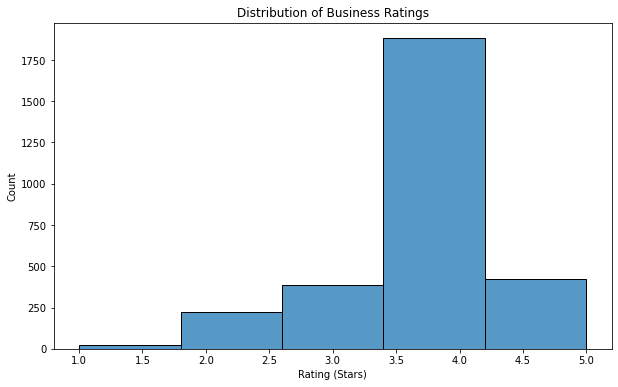


Business Ratings Summary:
count    2940.000000
mean        3.667517
std         0.617938
min         1.000000
25%         3.500000
50%         4.000000
75%         4.000000
max         5.000000
Name: stars, dtype: float64


In [ ]:
# Distribution of business ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=restaurants_train_df, x='stars', bins=5)
plt.title('Distribution of Business Ratings')
plt.xlabel('Rating (Stars)')
plt.ylabel('Count')
plt.show()

#summary statistics
print("\nBusiness Ratings Summary:")
print(restaurants_train_df['stars'].describe())

**Interpretation**


The plot represents the distribution of business ratings across the restaurants.

The x-axis on the plot is showing the rating scale (1 to 5 stars), while the y-axis represents the number of restaurants within each of the rating categories.

By looking at the histogram we can see that the majority of restaurants have ratings  between 3.5 and 4. There are fewer restaurants rated at the extreme ends of the scale, either 1 star or 5 stars. This indicates that while most businesses tend to fall within the "good" range of ratings, there are relatively few businesses with very low or very high ratings. This is a sort of normal distribution, to have a better idea.

The summary statistics provide more detailed insights to prove what was just said, showing that the mean rating is closer to 4 stars (3,66), suggesting a generally positive perception from the customers. The objective of this type of analysis is to gain a better understanding of customer satisfaction trends, which could be helpful to guide businesses in improving their service quality based on feedback.

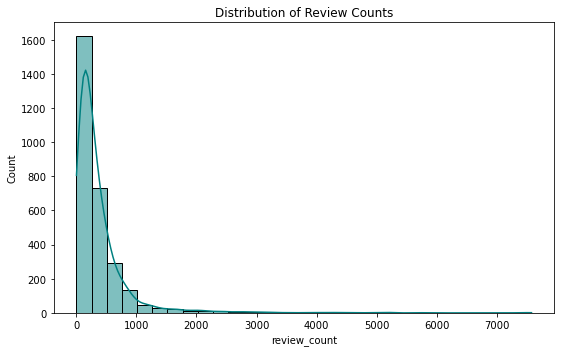

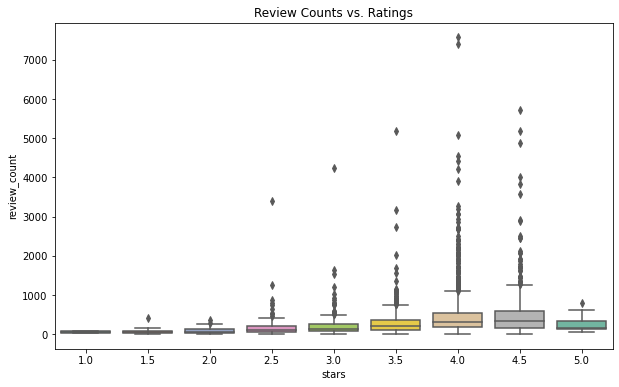

In [ ]:
# 3. Review count distributions across datasets
plt.figure(figsize=(15, 5))

# Plotting the review count distribution for restaurants_train_df
plt.subplot(1, 2, 1)
sns.histplot(restaurants_train_df['review_count'], kde=True, color="teal", bins=30)
plt.title("Distribution of Review Counts")

plt.tight_layout()
plt.show()

# 4. Boxplot of ratings (stars) vs. review counts
plt.figure(figsize=(10, 6))
sns.boxplot(x='stars', y='review_count', data=restaurants_train_df, palette="Set2")
plt.title("Review Counts vs. Ratings")
plt.show()


**Interpretation**

The first plot shows the distribution of review counts for restaurants, in which we can see a skewed pattern, where most restaurants have a relatively low number of reviews, but a few receive a very high number. We can see the long tail plot, and hence why we took this into consideration when treating the data

The second plot presents the relationship between review counts and restaurant ratings. It indicates that higher-rated restaurants generally tend to have more reviews. This shows that more popular restaurants, typically with higher ratings, accumulate a larger number of reviews.

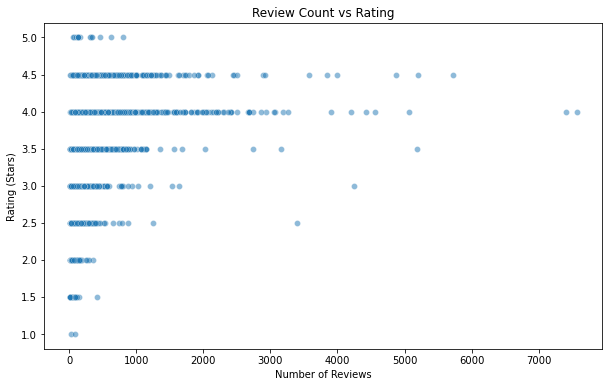

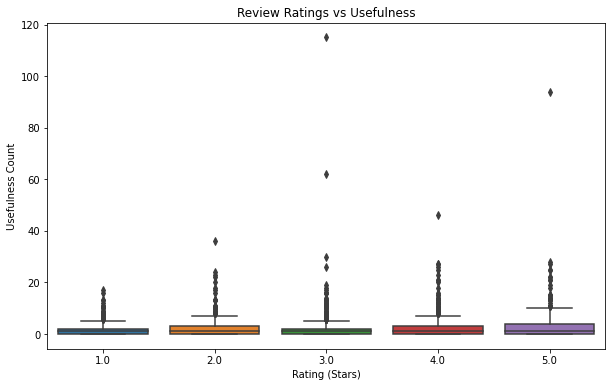

In [ ]:
# Scatter plot of review counts vs ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=restaurants_train_df, x='review_count', y='stars', alpha=0.5)
plt.title('Review Count vs Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating (Stars)')
plt.show()

# Box plot of review ratings vs usefulness
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='stars', y='useful')
plt.title('Review Ratings vs Usefulness')
plt.xlabel('Rating (Stars)')
plt.ylabel('Usefulness Count')
plt.show()

**Interpretation**

The scatter plot shows that higher-rated restaurants generally have more reviews, though some low-rated restaurants also have a large number of reviews. The box plot indicates that higher-rated reviews tend to receive more "useful" votes, with lower-rated reviews receiving fewer, highlighting greater engagement with positive reviews.


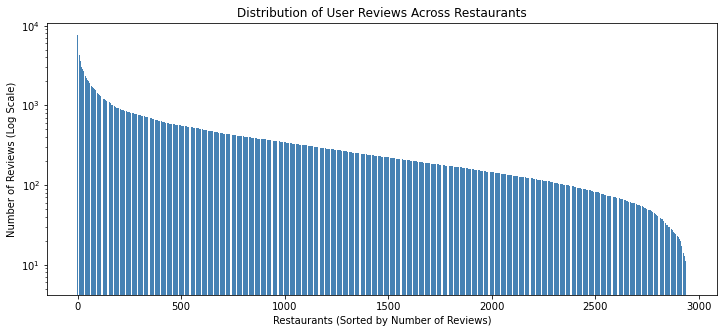

In [ ]:
# Sort the restaurants by the number of reviews in descending order
sorted_restaurants = restaurants_train_df.sort_values(by="review_count", ascending=False)

# Plotting the number of reviews on a log scale
plt.figure(figsize=(12, 5))
plt.bar(range(len(sorted_restaurants)), sorted_restaurants["review_count"], color="steelblue")

# Use log scale for better visualization of data spread
plt.yscale("log")

# Adding labels and title
plt.xlabel("Restaurants (Sorted by Number of Reviews)")
plt.ylabel("Number of Reviews (Log Scale)")
plt.title("Distribution of User Reviews Across Restaurants")

plt.show()


**Interpretation**

The bar plot displays the distribution of user reviews across restaurants. The plot highlights that a small number of restaurants receive a disproportionately high number of reviews, while the majority have lesss. This is typical in many datasets, where a few businesses (often the most popular or well-known) accumulate the majority of user feedback. Understanding this distribution is useful for businesses aiming to increase visibility and engagement, as it shows how concentrated user activity can be.

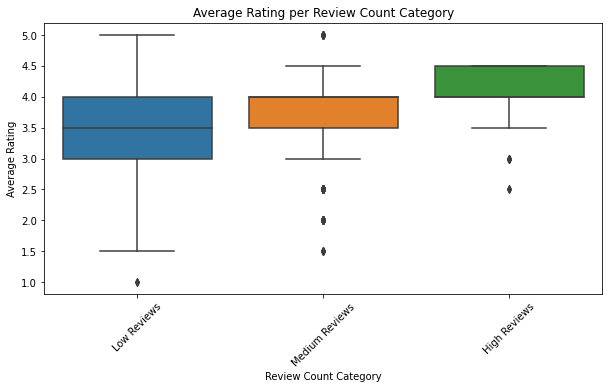

In [ ]:
# Splitting restaurants into three categories based on review count (as a proxy for price)
restaurants_train_df['price_category'] = 'Low Reviews'
restaurants_train_df.loc[restaurants_train_df['review_count'] > 100, 'price_category'] = 'Medium Reviews'
restaurants_train_df.loc[restaurants_train_df['review_count'] > 1000, 'price_category'] = 'High Reviews'

# Calculate the average rating (stars) per price category
avg_user_reviews_aux = restaurants_train_df.groupby('price_category')['stars'].mean().reset_index()

# Plotting a box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='price_category', y='stars', data=restaurants_train_df, order=['Low Reviews', 'Medium Reviews', 'High Reviews'])

# Adding labels, title, and rotating x-axis ticks
plt.xlabel("Review Count Category")
plt.ylabel("Average Rating")
plt.title("Average Rating per Review Count Category")
plt.xticks(rotation=45)

plt.show()


**Interpretation**

The box plot displays the average rating across restaurants divided into three categories. It shows that restaurants with higher review counts tend to have slightly higher average ratings, with the "High Reviews" category consistently showing higher ratings compared to the other categories. This makes sense as more reviews often lead to more balanced and accurate customer feedback, which can influence a restaurant’s perceived quality. Overall, we can say tha the plot provides insight into how review volume correlates with restaurant ratings, suggesting that popular restaurants tend to maintain higher average ratings.

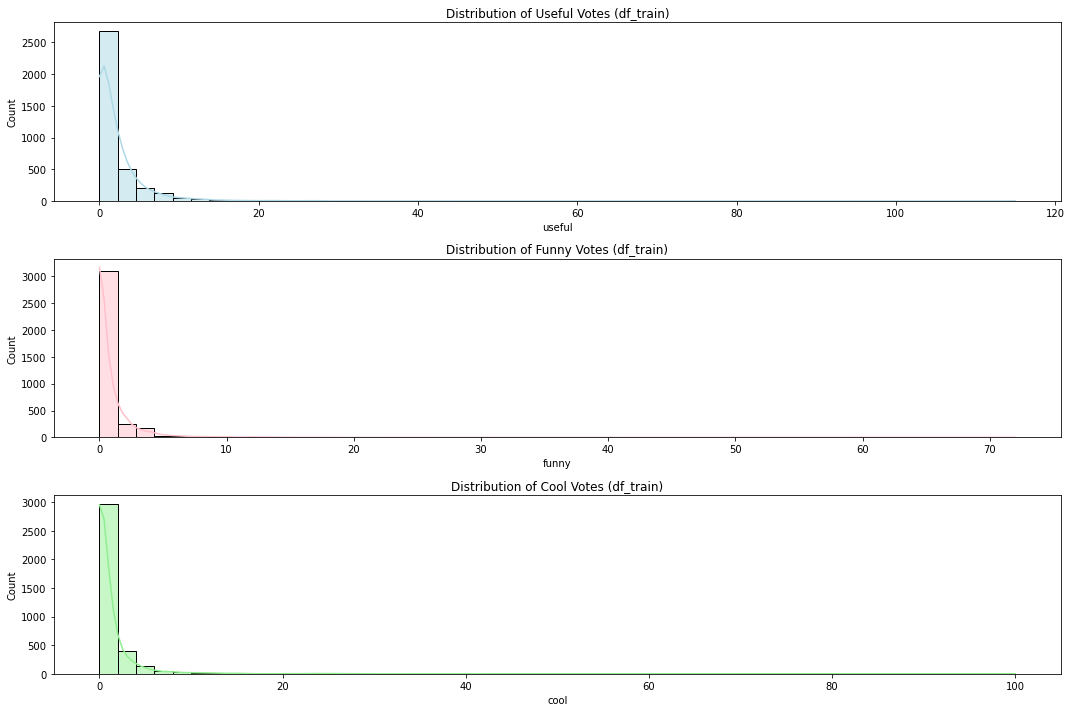

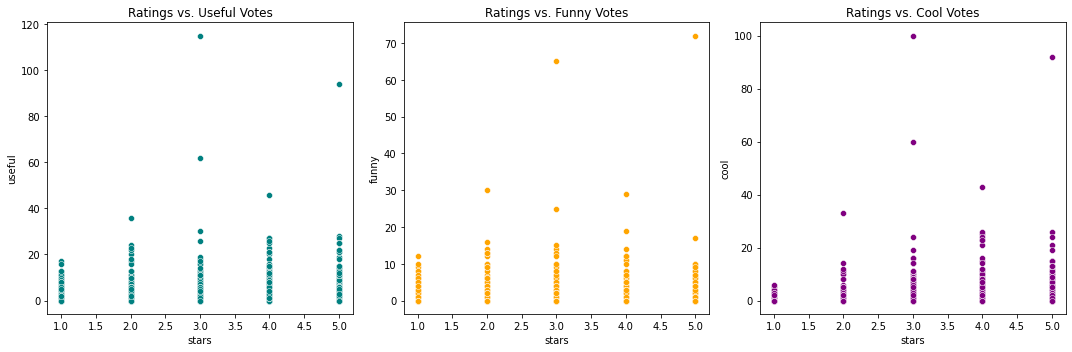

In [ ]:
# 5. Distribution of engagement metrics (useful, funny, cool)
plt.figure(figsize=(15, 10))

# Plotting distribution of useful votes
plt.subplot(3, 1, 1)
sns.histplot(df_train['useful'], kde=True, color="lightblue", bins=50)
plt.title("Distribution of Useful Votes (df_train)")

# Plotting distribution of funny votes
plt.subplot(3, 1, 2)
sns.histplot(df_train['funny'], kde=True, color="pink", bins=50)
plt.title("Distribution of Funny Votes (df_train)")

# Plotting distribution of cool votes
plt.subplot(3, 1, 3)
sns.histplot(df_train['cool'], kde=True, color="lightgreen", bins=50)
plt.title("Distribution of Cool Votes (df_train)")

plt.tight_layout()
plt.show()

# 6. Scatter plots of ratings vs. engagement metrics (useful, funny, cool)
plt.figure(figsize=(15, 5))

# Scatter plot of ratings vs. useful votes
plt.subplot(1, 3, 1)
sns.scatterplot(x='stars', y='useful', data=df_train, color="teal")
plt.title("Ratings vs. Useful Votes")

# Scatter plot of ratings vs. funny votes
plt.subplot(1, 3, 2)
sns.scatterplot(x='stars', y='funny', data=df_train, color="orange")
plt.title("Ratings vs. Funny Votes")

# Scatter plot of ratings vs. cool votes
plt.subplot(1, 3, 3)
sns.scatterplot(x='stars', y='cool', data=df_train, color="purple")
plt.title("Ratings vs. Cool Votes")

plt.tight_layout()
plt.show()


**Interpretation**

The first set of plots shows the distribution of engagement metrics (useful, funny, and cool votes) across reviews. All three metrics exhibit a highly skewed distribution, with most reviews receiving few or no engagement votes.

The second set of scatter plots examines the relationship between restaurant ratings (stars) and engagement metrics. For all three metrics (useful, funny, cool), the scatter plots show that higher-rated restaurants do not necessarily receive more engagement votes. This indicates that while higher ratings might correlate with more reviews (not always), they do not always correlate with increased user interaction in terms of usefulness, funniness, or coolness. This could suggest that reviews' perceived quality influences the level of engagement they receive rather than just their rating.

In [ ]:
from textblob import TextBlob
from scipy.stats import pearsonr

# Compute sentiment polarity of restaurant names (-1 = negative, 1 = positive)
restaurants_train_df["name_sentiment"] = restaurants_train_df["name"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Perform correlation test between sentiment and ratings (stars)
sentiment_corr, sentiment_p = pearsonr(restaurants_train_df["name_sentiment"].dropna(), restaurants_train_df["stars"].dropna())

# Display results
print("Restaurant Name Sentiment vs Rating - Pearson correlation:", sentiment_corr)
print("p-value:", sentiment_p)


Restaurant Name Sentiment vs Rating - Pearson correlation: 0.0039045278988656352
p-value: 0.8324025863019837


In [ ]:
restaurants_train_df['name_sentiment'].describe()

count    2940.000000
mean        0.014901
std         0.105742
min        -0.625000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: name_sentiment, dtype: float64

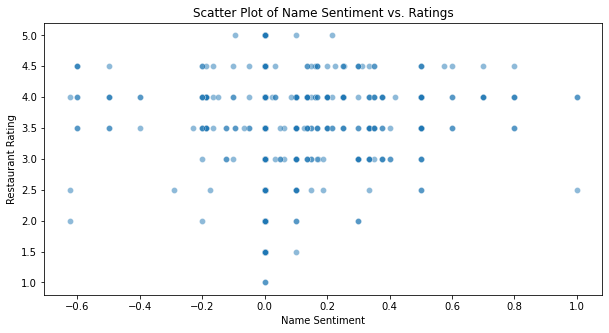

In [ ]:
# Scatter plot of restaurant name sentiment vs. ratings (stars)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=restaurants_train_df["name_sentiment"], y=restaurants_train_df["stars"], alpha=0.5)

# Adding labels and title
plt.xlabel("Name Sentiment")
plt.ylabel("Restaurant Rating")
plt.title("Scatter Plot of Name Sentiment vs. Ratings")

plt.show()


**Interpretation**

The scatter plot visualizes the relationship between the sentiment of restaurant names and their ratings (stars). The sentiment, calculated using TextBlob, ranges from -1 (negative sentiment) to 1 (positive sentiment). The plot reveals a bit of clear correlation between the sentiment of restaurant names and their ratings, as the points are slightly more condensed between -0.2 and 0.4 (alhtough there is a lot of dispersion). The Pearson correlation coefficient of 0.004 and the high p-value (0.83) suggest that there is no significant linear relationship between name sentiment and ratings. This makes sense, as a restaurant's name sentiment may not directly influence its overall customer rating, which is likely shaped by other factors such as food quality, service, and atmosphere.

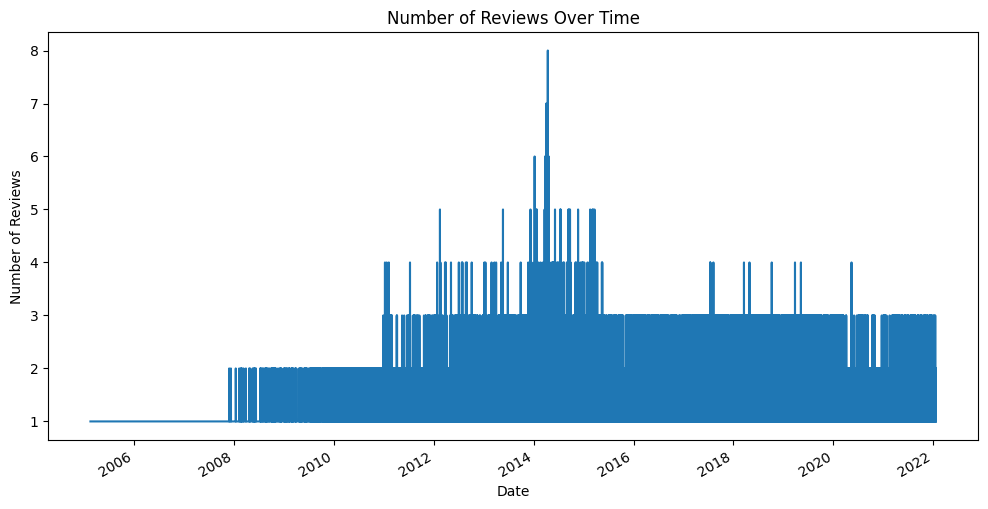

In [ ]:
# Convert date to datetime
review_df['date'] = pd.to_datetime(review_df['date'])

# Reviews over time
plt.figure(figsize=(12, 6))
review_df.groupby('date')['review_id'].count().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

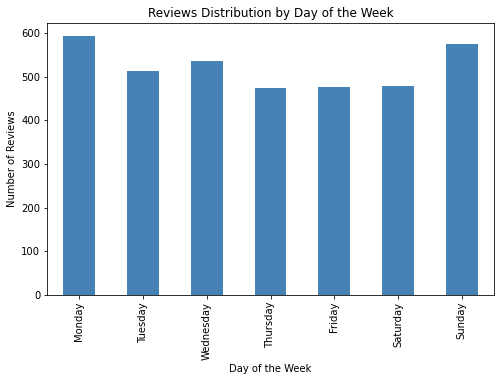

In [ ]:
# Convert 'date' column to datetime format
df_train["date"] = pd.to_datetime(df_train["date"])

# Extract the day of the week from the date
df_train["day_of_week"] = df_train["date"].dt.day_name()

# Count reviews per day of the week
reviews_per_day = df_train["day_of_week"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Plotting the reviews distribution by day of the week
plt.figure(figsize=(8, 5))
reviews_per_day.plot(kind="bar", color="steelblue")

# Adding labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Number of Reviews")
plt.title("Reviews Distribution by Day of the Week")

plt.show()


**Interpretation**

We can see, that contrary to many other datasets seen in class and in assignments, we actually have very similar rating counts in each day of the week. This is good to avoid training biases and shouldn't warrant action

# Evaluation Functions

This section contains the functions that are used to measure the performance of each algorithm. This is done per type of algorithm becasue each type needs and outputs different formats. *No output will be generated here*

The implementations generaly start with computing the Top-N restaurants recommended. We have decided N to be 10 for all algorithms to ensure consistency - and the value sounded representative of our business case

After this section, we start building the recommender systems and measuring their performance

## Non-Personalized

In [ ]:
# Get top-N recommended items for each user
def get_top_n(algo, trainset, n=10):
    top_n = defaultdict(list)
    # Iterate over all users (internal IDs 0..trainset.n_users-1)
    for uid in range(trainset.n_users):
        # Predict for all items not yet rated by this user
        predictions = []
        rated_items = {item for (item, _) in trainset.ur[uid]}
        for iid in range(trainset.n_items):
            if iid not in rated_items:
                est = algo.estimate(uid, iid)
                predictions.append((iid, est))
        # Sort by predicted rating descending and take top-N
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in predictions[:n]]
    return top_n

# Coverage: fraction of all items that appear in at least one user's top-N
def calculate_coverage_non_personalized(top_n, trainset):
    recommended_items = set()
    for uid, items in top_n.items():
        recommended_items.update(items)
    coverage = len(recommended_items) / trainset.n_items
    return coverage

# Personalization: 1 - average overlap in top-N lists between all user pairs
def calculate_personalization_non_personalized(top_n):
    users = list(top_n.keys())
    n_users = len(users)
    total_overlap = 0
    comparisons = 0
    for i in range(n_users):
        for j in range(i+1, n_users):
            set_i = set(top_n[users[i]])
            set_j = set(top_n[users[j]])
            intersection = len(set_i & set_j)
            union = len(set_i | set_j)
            if union > 0:
                total_overlap += intersection / union
            comparisons += 1
    if comparisons == 0:
        return 0
    avg_overlap = total_overlap / comparisons
    personalization = 1 - avg_overlap
    return personalization

# NDCG: compare recommended items vs. actual relevance from the test set
# testset is typically a list of (raw_user_id, raw_item_id, rating)
from collections import defaultdict
import math
import numpy as np

def calculate_ndcg_non_personalized(top_n, testset, trainset, k=10):
    """
    Calculate NDCG for non-personalized recommendations.

    Parameters:
        top_n: Dictionary mapping internal user IDs to a list of recommended item IDs.
        testset: List of (raw_user_id, raw_item_id, rating) tuples.
        trainset: Surprise trainset used to convert raw IDs to internal IDs.
        k: Consider top k items for evaluation.

    Returns:
        Average NDCG score over users with at least one relevant test item.
    """
    # Build a dict: user (internal ID) -> {item (internal ID): rating}
    user_ratings = defaultdict(dict)
    for raw_uid, raw_iid, true_r in testset:
        try:
            uid = trainset.to_inner_uid(raw_uid)
            iid = trainset.to_inner_iid(raw_iid)
        except ValueError:
            continue  # Skip users/items not in the trainset
        user_ratings[uid][iid] = true_r

    ndcg_values = []
    for uid, rec_items in top_n.items():
        if uid not in user_ratings:
            continue  # Skip if no test ratings exist for this user

        # Compute DCG from recommendations for this user
        dcg = 0.0
        for rank, iid in enumerate(rec_items[:k], start=1):
            rel = user_ratings[uid].get(iid, 0)
            dcg += (2**rel - 1) / math.log2(rank + 1)

        # Compute IDCG using the best possible ordering of the user's test ratings
        test_items = list(user_ratings[uid].items())
        if not test_items:
            continue  # No test ratings available, skip this user
        test_items_sorted = sorted(test_items, key=lambda x: x[1], reverse=True)[:k]
        idcg = 0.0
        for rank, (_, rating) in enumerate(test_items_sorted, start=1):
            idcg += (2**rating - 1) / math.log2(rank + 1)

        # Only include users where IDCG is non-zero (i.e. there is at least one relevant test item)
        if idcg > 0:
            ndcg_values.append(dcg / idcg)
        # Otherwise, skip this user rather than appending a 0 that could bias the overall average

    return np.mean(ndcg_values) if ndcg_values else 0.0


## Collaborative

In [ ]:
def get_top_n_collab(algo, trainset, n=10):
    from collections import defaultdict
    top_n = defaultdict(list)
    for uid in range(trainset.n_users):
        rated_items = {item for (item, _) in trainset.ur[uid]}
        predictions = []
        for iid in range(trainset.n_items):
            if iid not in rated_items:
                try:
                    est = algo.estimate(uid, iid)
                    # If est is a dict, extract the numeric value (e.g., 'est')
                    if isinstance(est, dict):
                        est = est.get('est', 0.0)
                    est = float(est)
                except Exception:
                    # Optionally, use a fallback value (could be global mean if available)
                    est = 0.0
                predictions.append((iid, est))
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in predictions[:n]]
    return top_n


## Content

In [ ]:
import numpy as np
import math

def get_top_n_content(recommender, n=5):
    """
    For each restaurant index i, get its top-N most similar restaurants.
    Returns a dict: { i: [list of recommended indices] }
    """
    top_n = {}
    num_restaurants = len(recommender.restaurants_df)

    for i in range(num_restaurants):
        # Similarity scores for restaurant i
        sim_scores = list(enumerate(recommender.similarity_matrix[i]))
        # Sort descending by similarity
        sim_scores.sort(key=lambda x: x[1], reverse=True)
        # Exclude itself
        sim_scores = sim_scores[1:n+1]
        # Store the indices of the top-N similar items
        top_n[i] = [idx for (idx, _) in sim_scores]

    return top_n

def calculate_coverage(top_n, total_items):
    """
    Fraction of items that appear in at least one top-N list.
    """
    recommended_items = set()
    for i in top_n:
        recommended_items.update(top_n[i])
    return len(recommended_items) / total_items

def calculate_personalization(top_n):
    """
    1 - average Jaccard similarity of top-N lists across all pairs of restaurants.
    If all lists are identical, personalization is 0; if all are disjoint, it's close to 1.
    """
    indices = list(top_n.keys())
    n_items = len(indices)
    if n_items < 2:
        return 0.0

    total_jaccard = 0.0
    pairs_count = 0

    for i in range(n_items):
        for j in range(i + 1, n_items):
            set_i = set(top_n[indices[i]])
            set_j = set(top_n[indices[j]])
            intersection = len(set_i & set_j)
            union = len(set_i | set_j)
            if union > 0:
                total_jaccard += intersection / union
            pairs_count += 1

    avg_jaccard = total_jaccard / pairs_count if pairs_count else 0.0
    return 1.0 - avg_jaccard

def calculate_rmse_content(recommender, top_n):
    """
    For each restaurant i, predict its rating by averaging the stars of its top-N neighbors,
    then compare to the actual rating of restaurant i to compute RMSE.
    """
    errors = []
    df = recommender.restaurants_df

    for i, neighbors in top_n.items():
        actual = df.iloc[i]['stars']
        if not neighbors:
            # If no neighbors, skip or fall back to something like a global mean
            continue

        # Predicted rating = average stars of the top-N similar restaurants
        predicted = df.iloc[neighbors]['stars'].mean()
        errors.append((actual - predicted)**2)

    if not errors:
        return 0.0

    mse = sum(errors) / len(errors)
    return math.sqrt(mse)

In [ ]:
def calculate_mae_content(recommender, top_n):
    """
    For each restaurant i, predict its rating by averaging the stars of its top-N neighbors,
    then compare to the actual rating of restaurant i to compute MAE.
    """
    errors = []
    df = recommender.restaurants_df

    for i, neighbors in top_n.items():
        actual = df.iloc[i]['stars']
        if not neighbors:
            continue  # Skip if no neighbors

        predicted = df.iloc[neighbors]['stars'].mean()
        errors.append(abs(actual - predicted))

    if not errors:
        return 0.0

    return sum(errors) / len(errors)

## Hybrid

In [ ]:
def calculate_rmse_hybrid(weighted_hybrid, testset):
    """
    Calculate RMSE for the weighted hybrid recommender.

    Args:
        weighted_hybrid: Your WeightedHybridRecommender instance.
        testset: List of tuples (user_id, business_id, actual_rating).

    Returns:
        RMSE value.
    """
    squared_errors = []
    for user, business, actual in testset:
        try:
            pred = weighted_hybrid.recommend(user, business)
            predicted = pred['weighted_score']
            squared_errors.append((actual - predicted) ** 2)
        except Exception:
            # Skip if prediction fails for any reason
            continue
    mse = np.mean(squared_errors) if squared_errors else 0
    return math.sqrt(mse)

def calculate_mae_hybrid(hybrid_model, testset):
    """
    Calculate MAE for a hybrid recommender.

    Args:
        hybrid_model: Your hybrid recommender instance (Weighted or Switching).
        testset: List of tuples (user_id, business_id, actual_rating).

    Returns:
        MAE value.
    """
    absolute_errors = []
    for user, business, actual in testset:
        try:
            pred = hybrid_model.recommend(user, business)
            predicted = pred['weighted_score']
            absolute_errors.append(abs(actual - predicted))
        except Exception:
            continue
    return np.mean(absolute_errors) if absolute_errors else 0


def get_top_n_hybrid(weighted_hybrid, user_list, n=10):
    """
    For each user in user_list, obtain top-N recommended business IDs
    using the weighted hybrid recommender.

    Args:
        weighted_hybrid: Your WeightedHybridRecommender instance.
        user_list: Iterable of user_ids.
        n: Number of recommendations per user.

    Returns:
        Dictionary mapping user_id -> list of recommended business_ids.
    """
    top_n = {}
    for user in user_list:
        recs = weighted_hybrid.get_recommendations(user, n)
        # Extract business_id from each recommendation dictionary
        recommended_ids = [rec['business_id'] for rec in recs]
        top_n[user] = recommended_ids
    return top_n


def calculate_coverage_hybrid(top_n, candidate_items):
    """
    Calculate coverage: fraction of candidate items that appear
    in at least one user's top-N list.

    Args:
        top_n: Dictionary mapping user_id to list of recommended business_ids.
        candidate_items: A set or list of all candidate business IDs.

    Returns:
        Coverage value (0 to 1).
    """
    recommended_items = set()
    for recs in top_n.values():
        recommended_items.update(recs)
    return len(recommended_items) / len(candidate_items) if candidate_items else 0


def calculate_personalization_hybrid(top_n):
    """
    Calculate personalization as 1 minus the average Jaccard similarity
    between all pairs of users' top-N recommendation lists.

    Args:
        top_n: Dictionary mapping user_id to list of recommended business_ids.

    Returns:
        Personalization value (closer to 1 means more personalized).
    """
    users = list(top_n.keys())
    n_users = len(users)
    total_overlap = 0.0
    comparisons = 0
    for i in range(n_users):
        for j in range(i + 1, n_users):
            set_i = set(top_n[users[i]])
            set_j = set(top_n[users[j]])
            union_size = len(set_i | set_j)
            if union_size > 0:
                jaccard = len(set_i & set_j) / union_size
            else:
                jaccard = 0
            total_overlap += jaccard
            comparisons += 1
    avg_overlap = total_overlap / comparisons if comparisons else 0
    return 1 - avg_overlap

## Context

In [ ]:
import numpy as np
import math
import pandas as pd
from collections import defaultdict

def evaluate_rmse_context(model, df_test):
    """
    Compute RMSE for the context-aware recommender.

    Args:
        model: scikit-learn pipeline trained on features.
        df_test: DataFrame with columns:
                 ['user_id', 'business_id', 'user_review_count', 'user_avg_stars', 'day_of_week', 'season', 'stars']

    Returns:
        RMSE value.
    """
    # Extract features and target
    X_test = df_test[['user_id', 'business_id', 'user_review_count', 'user_avg_stars', 'day_of_week', 'season']]
    y_test = df_test['stars']
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    return rmse

def get_top_n_context(model, user_list, candidate_df, user_stats, test_context, n=10):
    """
    Generate top-N recommendations for each user using the context-aware model.

    Args:
        model: Trained scikit-learn pipeline.
        user_list: Iterable of user_ids for which to generate recommendations.
        candidate_df: DataFrame of candidate items with at least a 'business_id' column.
        user_stats: DataFrame with columns ['user_id', 'user_review_count', 'user_avg_stars'].
        test_context: Dict mapping user_id -> {'day_of_week': int, 'season': str}
        n: Number of recommendations to return per user.

    Returns:
        Dictionary mapping user_id -> list of recommended business_ids.
    """
    top_n = {}
    for user in user_list:
        # Get user stats for this user
        user_row = user_stats[user_stats['user_id'] == user]
        if user_row.empty:
            continue
        user_review_count = user_row['user_review_count'].values[0]
        user_avg_stars = user_row['user_avg_stars'].values[0]
        # Get context for this user (from test_context)
        if user in test_context:
            day_of_week = test_context[user]['day_of_week']
            season = test_context[user]['season']
        else:
            day_of_week = 0
            season = 'winter'

        # Construct candidate features DataFrame for this user
        df_candidates = candidate_df[['business_id']].copy()
        df_candidates['user_id'] = user
        df_candidates['user_review_count'] = user_review_count
        df_candidates['user_avg_stars'] = user_avg_stars
        df_candidates['day_of_week'] = day_of_week
        df_candidates['season'] = season

        X_candidates = df_candidates[['user_id', 'business_id', 'user_review_count', 'user_avg_stars', 'day_of_week', 'season']]
        preds = model.predict(X_candidates)
        df_candidates['pred_rating'] = preds
        df_candidates = df_candidates.sort_values(by='pred_rating', ascending=False)
        top_n[user] = df_candidates['business_id'].head(n).tolist()
    return top_n

def calculate_coverage_context(top_n, candidate_items):
    """
    Calculate coverage: fraction of candidate items that appear in at least one user's top-N list.

    Args:
        top_n: Dictionary mapping user_id -> list of recommended business_ids.
        candidate_items: Iterable of candidate business_ids.

    Returns:
        Coverage (0 to 1).
    """
    recommended_items = set()
    for recs in top_n.values():
        recommended_items.update(recs)
    return len(recommended_items) / len(candidate_items) if candidate_items else 0

def calculate_personalization_context(top_n):
    """
    Calculate personalization: 1 minus the average Jaccard similarity between users' top-N recommendation lists.

    Args:
        top_n: Dictionary mapping user_id -> list of recommended business_ids.

    Returns:
        Personalization value (closer to 1 means more personalized).
    """
    users = list(top_n.keys())
    n_users = len(users)
    total_overlap = 0.0
    comparisons = 0
    for i in range(n_users):
        for j in range(i + 1, n_users):
            set_i = set(top_n[users[i]])
            set_j = set(top_n[users[j]])
            union_size = len(set_i | set_j)
            if union_size > 0:
                total_overlap += len(set_i & set_j) / union_size
            comparisons += 1
    avg_overlap = total_overlap / comparisons if comparisons else 0
    return 1 - avg_overlap

def calculate_ndcg_context(top_n, df_test, k=10):
    """
    Calculate NDCG for the context-aware recommender.
    Assumes a leave-one-out setup where each user in df_test has one test rating.
    Args:
        top_n: Dictionary mapping user_id -> list of recommended business_ids.
        df_test: DataFrame with columns ['user_id', 'business_id', 'stars'] for the test set.
        k: Consider top k items for NDCG.
    Returns:
        Average NDCG over users.
    """
    ndcg_values = []

    # Create a dictionary mapping user_id to a dict with 'business_id' and 'stars'
    test_dict = df_test.set_index('user_id')[['business_id', 'stars']].to_dict('index')

    # Iterate over each user and their recommendations
    for user, rec_list in top_n.items():
        # Skip users that don't have a test rating in the test set
        if user not in test_dict:
            continue

        # Retrieve the true test business and its rating for this user
        test_business = test_dict[user]['business_id']
        test_rating = test_dict[user]['stars']

        # If the test business is in the recommendation list, calculate its rank-based gain
        if test_business in rec_list:
            rank = rec_list.index(test_business) + 1  # Ranks start at 1
            # Compute Discounted Cumulative Gain (DCG)
            dcg = (2 ** test_rating - 1) / math.log2(rank + 1)
            # Ideal DCG is achieved if the test business were ranked first
            idcg = (2 ** test_rating - 1)
            ndcg_values.append(dcg / idcg)
        else:
            # If the true item is not recommended, NDCG is 0 for this user
            ndcg_values.append(0)

    # Return the average NDCG over all users
    return np.mean(ndcg_values) if ndcg_values else 0

## LightFm

In [ ]:
def compute_rmse_lightfm(model, interaction_matrix):
    """
    Compute RMSE between actual values in 'interaction_matrix' and
    LightFM's predicted scores.

    Args:
        model: trained LightFM model
        interaction_matrix: sparse matrix with actual ratings in .data

    Returns:
        rmse: root mean squared error
    """
    coo = interaction_matrix.tocoo()

    # Actual numeric ratings
    actual = coo.data

    # Predicted scores from LightFM
    predicted = model.predict(coo.row, coo.col)

    # Compute RMSE
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def compute_mae_lightfm(model, interaction_matrix):
    """
    Compute MAE between actual values in 'interaction_matrix' and
    LightFM's predicted scores.

    Args:
        model: trained LightFM model
        interaction_matrix: sparse matrix with actual ratings in .data

    Returns:
        mae: mean absolute error
    """
    coo = interaction_matrix.tocoo()

    # Actual numeric ratings
    actual = coo.data

    # Predicted scores from LightFM
    predicted = model.predict(coo.row, coo.col)

    # Compute MAE
    mae = np.mean(np.abs(actual - predicted))
    return mae

def compute_coverage_lightfm(model, interaction_matrix, user_mapping, item_mapping, n=10):
    """
    Compute coverage: fraction of items recommended at least once
    in the top-N list across all users, using your get_recommendations function.

    Args:
        model: trained LightFM model
        interaction_matrix: user-item interaction matrix (sparse)
        user_mapping: dict mapping user IDs -> row indices
        item_mapping: dict mapping item IDs -> column indices
        n: number of top items to recommend per user

    Returns:
        coverage: fraction of items that appear in top-N lists
    """
    recommended_items = set()

    for user_id in user_mapping.keys():
        # Get the top-N recommendations for this user
        recs = get_recommendations(
            model=model,
            user_id=user_id,
            user_mapping=user_mapping,
            item_mapping=item_mapping,
            interaction_matrix=interaction_matrix,
            num_recommendations=n,
            exclude_seen=True
        )
        # recs is a list of (item_id, score) tuples
        recommended_items.update([item_id for (item_id, _) in recs])

    # Coverage is the fraction of distinct items recommended
    total_items = interaction_matrix.shape[1]  # number of columns = number of items
    coverage = len(recommended_items) / total_items if total_items else 0
    return coverage

def compute_personalization_lightfm(model, interaction_matrix, user_mapping, item_mapping, n=10):
    """
    Compute personalization: 1 - average Jaccard similarity
    between users' top-N recommendation lists.

    Args:
        model: trained LightFM model
        interaction_matrix: user-item interaction matrix (sparse)
        user_mapping: dict mapping user IDs -> row indices
        item_mapping: dict mapping item IDs -> column indices
        n: number of top items to recommend per user

    Returns:
        personalization: value in [0, 1], where higher = more personalized
    """
    user_ids = list(user_mapping.keys())
    user_top_n = []

    # Collect each user's top-N items
    for user_id in user_ids:
        recs = get_recommendations(
            model=model,
            user_id=user_id,
            user_mapping=user_mapping,
            item_mapping=item_mapping,
            interaction_matrix=interaction_matrix,
            num_recommendations=n,
            exclude_seen=True
        )
        recommended_item_ids = {item_id for (item_id, _) in recs}
        user_top_n.append(recommended_item_ids)

    # Calculate average Jaccard overlap
    total_overlap = 0.0
    comparisons = 0
    for i in range(len(user_ids)):
        for j in range(i + 1, len(user_ids)):
            set_i = user_top_n[i]
            set_j = user_top_n[j]
            union_size = len(set_i | set_j)
            if union_size > 0:
                overlap = len(set_i & set_j) / union_size
                total_overlap += overlap
            comparisons += 1

    avg_overlap = total_overlap / comparisons if comparisons else 0
    personalization = 1 - avg_overlap
    return personalization

## Comparison

In [ ]:
def plot_metrics_bar(results_df):
    """
    Create side-by-side bar charts for RMSE, Coverage, and Personalization.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # RMSE
    sns.barplot(data=results_df, x='Recommender', y='RMSE', ax=axes[0])
    axes[0].set_title('RMSE')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

    # Coverage
    sns.barplot(data=results_df, x='Recommender', y='Coverage', ax=axes[1])
    axes[1].set_title('Coverage')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

    # Personalization
    sns.barplot(data=results_df, x='Recommender', y='Personalization', ax=axes[2])
    axes[2].set_title('Personalization')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def plot_coverage_vs_personalization(results_df):
    """
    Create a scatter plot of Coverage vs. Personalization.
    Point size reflects RMSE.
    """
    plt.figure(figsize=(7, 6))
    # We'll map RMSE to the size of the markers
    sns.scatterplot(
        data=results_df,
        x='Coverage', y='Personalization',
        hue='Recommender', size='RMSE',
        sizes=(50, 300),  # min to max marker size
        alpha=0.7
    )
    plt.title('Coverage vs. Personalization')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Ensemble

In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
from collections import defaultdict

def evaluate_ensemble(df_test, top_n=10):
    """
    Compute RMSE, coverage, personalization, and NDCG on df_test using ensemble_recommendations.

    Args:
        df_test (pd.DataFrame): Must have columns ['user_id', 'business_id', 'stars'].
        top_n (int): Number of recommendations per user.

    Returns:
        dict with keys ['rmse', 'coverage', 'personalization', 'ndcg'] and their computed values.
    """
    # 1) Gather recommendation lists for each user in df_test
    unique_users = df_test['user_id'].unique()
    user_recs = {}  # user_id -> list of (business_id, predicted_rating, actual_rating_if_known)

    for user_id in unique_users:
        # ensemble_recommendations should return a DataFrame with at least a 'business_id' column.
        recs_df = ensemble_recommendations(user_id, num_recommendations=top_n)

        # For a naive predicted rating, we use the restaurant's own 'stars' if available;
        # otherwise, we default to a fallback value (e.g., 3.0).
        if 'stars' in recs_df.columns:
            recs_df['predicted_rating'] = recs_df['stars']
        else:
            recs_df['predicted_rating'] = 3.0

        # Merge with test ratings for the current user
        merged = pd.merge(
            recs_df[['business_id', 'predicted_rating']],
            df_test[df_test['user_id'] == user_id][['business_id', 'stars']],
            on='business_id',
            how='left',
            suffixes=('_pred', '_actual')
        )

        # Save recommendations as list of tuples: (business_id, predicted, actual)
        user_recs[user_id] = list(zip(
            merged['business_id'],
            merged['predicted_rating'],
            merged['stars']  # Note: this may be NaN if the user has no test rating for the item
        ))

    # 2) Coverage: fraction of unique items recommended vs. total items in restaurants_train_df
    recommended_items = set()
    for user_id, recs in user_recs.items():
        for (biz_id, _, _) in recs:
            recommended_items.add(biz_id)
    total_items = len(restaurants_train_df['business_id'].unique())
    coverage = len(recommended_items) / total_items if total_items else 0.0

    # 3) Personalization: 1 - average Jaccard similarity among users' top-N lists
    user_item_sets = {user_id: set([r[0] for r in recs]) for user_id, recs in user_recs.items()}
    user_ids = list(user_item_sets.keys())
    n_users = len(user_ids)
    if n_users < 2:
        personalization = 0.0
    else:
        total_jaccard = 0.0
        pairs_count = 0
        for i in range(n_users):
            for j in range(i + 1, n_users):
                set_i = user_item_sets[user_ids[i]]
                set_j = user_item_sets[user_ids[j]]
                intersection = len(set_i & set_j)
                union = len(set_i | set_j)
                if union > 0:
                    total_jaccard += intersection / union
                pairs_count += 1
        avg_jaccard = total_jaccard / pairs_count if pairs_count else 0.0
        personalization = 1.0 - avg_jaccard

    # 4) RMSE: compare predicted rating vs. actual rating from df_test
    squared_errors = []
    for user_id, recs in user_recs.items():
        for (biz_id, pred, actual) in recs:
            if pd.notnull(actual):
                squared_errors.append((pred - actual) ** 2)
    rmse = sqrt(sum(squared_errors) / len(squared_errors)) if squared_errors else 0.0

    # 5) nDCG: measure ranking quality. Define relevance as 1 if actual rating >= 4, else 0.
    def dcg_at_k(relevances):
        dcg = 0.0
        for i, rel in enumerate(relevances, start=1):
            dcg += rel / np.log2(i + 1)
        return dcg

    ndcg_values = []
    for user_id, recs in user_recs.items():
        relevances = []
        for (biz_id, _, actual) in recs:
            # Only mark as relevant if actual rating exists and is >= 4
            relevances.append(1 if pd.notnull(actual) and actual >= 4 else 0)

        dcg_val = dcg_at_k(relevances)
        # For the ideal ranking, sort relevances in descending order
        ideal_relevances = sorted(relevances, reverse=True)
        idcg_val = dcg_at_k(ideal_relevances)

        # Only include users with a nonzero ideal DCG to avoid biasing the average
        if idcg_val > 0:
            ndcg_values.append(dcg_val / idcg_val)

    ndcg = np.mean(ndcg_values) if ndcg_values else 0.0

    return {
        'rmse': rmse,
        'coverage': coverage,
        'personalization': personalization,
        'ndcg': ndcg
    }


# Non-Personalized Algorithms

In this section, we will build two algorithms: Random RS + Popular RS

## Random

This has been built using the simple implementation we have learned in class

In [ ]:
class RandomRecommender(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        ratings = [r for (_, _, r) in self.trainset.all_ratings()]
        self.min_rating = min(ratings)
        self.max_rating = max(ratings)
        return self

    def estimate(self, u, i):
        # Truly random predictions
        return random.uniform(self.min_rating, self.max_rating)

## Popular

This has been built using the simple implementation we have learned in class

In [ ]:
class PopularRecommender(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        # Calculate item popularity
        self.item_ratings = defaultdict(list)
        for (_, iid, rating) in trainset.all_ratings():
            self.item_ratings[iid].append(rating)

        # Calculate mean ratings and counts
        self.item_means = {}
        self.item_counts = {}
        for iid, ratings in self.item_ratings.items():
            self.item_means[iid] = np.mean(ratings)
            self.item_counts[iid] = len(ratings)

        # Get popularity threshold
        self.count_threshold = np.percentile(list(self.item_counts.values()), 50)
        self.global_mean = np.mean([r for (_, _, r) in trainset.all_ratings()])
        return self

    def estimate(self, u, i):
        if i in self.item_means and self.item_counts[i] >= self.count_threshold:
            return self.item_means[i]
        return self.global_mean * 0.5  # Strong penalty for unpopular items

## Training and Testing

In this section, we apply cross-validation in order to measure the performance of our algorithms

In [ ]:
# For storing results
fold_results = []

# Define number of folds
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Convert to array for easy indexing
df_all = df_train[['user_id', 'business_id', 'stars']].copy().reset_index(drop=True)
df_all_array = df_all.values

# Begin cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(df_all_array)):
    print(f"\n=== Fold {fold + 1} / {n_folds} ===")

    df_train = pd.DataFrame(df_all_array[train_idx], columns=['user_id', 'business_id', 'stars'])
    df_test = pd.DataFrame(df_all_array[test_idx], columns=['user_id', 'business_id', 'stars'])

    # Surprise format
    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(df_train, reader)
    trainset = train_data.build_full_trainset()
    testset = list(zip(df_test['user_id'], df_test['business_id'], df_test['stars']))

    # Train and evaluate Random Recommender
    random_rs = RandomRecommender()
    random_rs.fit(trainset)

    top_n_random = get_top_n(random_rs, trainset, n=10)
    cov_random = calculate_coverage_non_personalized(top_n_random, trainset)
    pers_random = calculate_personalization_non_personalized(top_n_random)
    predictions_random = random_rs.test(testset)
    rmse_random = accuracy.rmse(predictions_random, verbose=False)
    mae_random = accuracy.mae(predictions_random, verbose=False)
    #ndcg_random = calculate_ndcg(top_n_random, testset)

    # Train and evaluate Popular Recommender
    popular_rs = PopularRecommender()
    popular_rs.fit(trainset)

    top_n_popular = get_top_n(popular_rs, trainset, n=10)
    cov_popular = calculate_coverage_non_personalized(top_n_popular, trainset)
    pers_popular = calculate_personalization_non_personalized(top_n_popular)
    predictions_popular = popular_rs.test(testset)
    rmse_popular = accuracy.rmse(predictions_popular, verbose=False)
    mae_popular = accuracy.mae(predictions_popular, verbose=False)
    #ndcg_popular = calculate_ndcg(top_n_popular, testset)

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'rmse_random': rmse_random,
        'mae_random': mae_random,
        'coverage_random': cov_random,
        'personalization_random': pers_random,
        #'ndcg_random': ndcg_random,
        'rmse_popular': rmse_popular,
        'mae_popular': mae_popular,
        'coverage_popular': cov_popular,
        'personalization_popular': pers_popular,
        #'ndcg_popular': ndcg_popular,
    })

# Convert to DataFrame for analysis
cvv_df = pd.DataFrame(fold_results)

# Print fold-wise results
print("\n=== CVV Fold Results ===")
display(cvv_df)

# Print mean (global) results
print("\n=== CVV Mean Results (Global) ===")
print(cvv_df.mean(numeric_only=True).round(4))


=== Fold 1 / 5 ===

=== Fold 2 / 5 ===

=== Fold 3 / 5 ===

=== Fold 4 / 5 ===

=== Fold 5 / 5 ===

=== CVV Fold Results ===


,fold,rmse_random,mae_random,coverage_random,personalization_random,rmse_popular,mae_popular,coverage_popular,personalization_popular
0,1,1.730359,1.431441,1.0,0.992733,1.937116,1.644919,0.016552,0.005147
1,2,1.609907,1.317332,1.0,0.992714,1.808041,1.535246,0.015299,0.005183
2,3,1.662753,1.370060,1.0,0.992622,1.823701,1.585882,0.016575,0.005125
3,4,1.543766,1.236429,1.0,0.992726,1.850945,1.564172,0.016438,0.005111
4,5,1.439937,1.163559,1.0,0.992650,1.928567,1.674921,0.015299,0.005176



=== CVV Mean Results (Global) ===
fold                       3.0000
rmse_random                1.5973
mae_random                 1.3038
coverage_random            1.0000
personalization_random     0.9927
rmse_popular               1.8697
mae_popular                1.6010
coverage_popular           0.0160
personalization_popular    0.0051
dtype: float64


**Random RS:**

- RMSE (1.43 – 1.73): As expected, the RMSE is high and inconsistent across folds. Since the predictions are random, so they’re far from true ratings.

- MAE (1.16 – 1.43): Similar pattern to RMSE and also expected

- Coverage (1.0): Perfect coverage — all items are equally likely to be recommended, which makes sense for a random model.

- Personalization (1.0): Perfect personalization — each user gets completely different recommendations, which again makes sense since they're random.

<br>

**Popular RS:**

- RMSE (1.80 – 1.93): Worse than the random model in RMSE — which can happen because it gives same top items to everyone, ignoring individual preferences.

- MAE (1.53 – 1.67): Also worse than random. Popularity bias harms personalization and accuracy.

- Coverage (~1.5%): Very low coverage — only a small subset of items are recommended This makes complete sense since only the most popular restaurants are being recommended.

- Personalization (~0.0051): Extremely low personalization. This also makes sense since we are recommending the same items to everyone.

Now we train the models with the full trainset so that we obtain those extra performance points by having more data

In [ ]:
# Train models
print("=== TRAINING RECOMMENDERS ===")
random_rs = RandomRecommender()
random_rs.fit(trainset_reviews)

popular_rs = PopularRecommender()
popular_rs.fit(trainset_reviews)

=== TRAINING RECOMMENDERS ===


We will store these results for future comparison

In [ ]:
# Storing results in a dataset
non_personalized_results = {
    'Recommender': ['Random', 'Popular'],
    'RMSE': [1.5973, 1.8697],
    'MAE': [1.3038, 1.6010],
    'Coverage': [1.0000, 0.0160],
    'Personalization': [0.9927, 0.0051]
}
non_personalized_results_df = pd.DataFrame(non_personalized_results)
non_personalized_results_df.head()

,Recommender,RMSE,MAE,Coverage,Personalization
0,Random,1.5973,1.3038,1.000,0.9927
1,Popular,1.8697,1.6010,0.016,0.0051


# Collaborative filtering Algorithms

In this section, we will create using the class's implementation of an item-based, user-based, and model-based recommender systems. We will measure the performance like before

We have decided to use collaborative filtering since it leverages user preferences to provide personalized recommendations based on similar users or items. Unlike non-personalized algorithms, it adapts to individual tastes, increasing relevance, engagement, and satisfaction by uncovering hidden patterns in user-item interactions.
<br>

Cold-start problems,  and data sparsity can reduce accuracy and increase computational cost.

## Item-based

In [ ]:
knn_item = KNNBasic(k=5, min_k=1, sim_options={'name': 'cosine', 'user_based': False})

## User-based

In [ ]:
user_based_knn = KNNBasic(k=5, min_k=1, sim_options={'name': 'cosine', 'user_based': True})

## Model-based

In [ ]:
# SVD
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=19)

## Training and Test

In [ ]:
from sklearn.model_selection import KFold
from surprise import Dataset, Reader
import pandas as pd
import numpy as np

# Load entire dataset into array
df_all = trainset_reviews.build_testset()
df_all_df = pd.DataFrame(df_all, columns=["user_id", "business_id", "stars"])

# Prepare 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cvv_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df_all_df)):
    print(f"\n=== Fold {fold+1} / 5 ===")

    df_train = df_all_df.iloc[train_idx].copy()
    df_test = df_all_df.iloc[test_idx].copy()

    # Load into Surprise format
    reader = Reader(rating_scale=(1, 5))
    data_train = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
    trainset = data_train.build_full_trainset()
    testset = list(zip(df_test['user_id'], df_test['business_id'], df_test['stars']))

    # ---------- Item-based CF ----------
    knn_item.fit(trainset)
    top_n_item = get_top_n_collab(knn_item, testset_reviews, n=10)
    cov_item = calculate_coverage_non_personalized(top_n_item, testset_reviews)
    pers_item = calculate_personalization_non_personalized(top_n_item)
    #ndcg_item = calculate_ndcg(top_n_item, testset_reviews, trainset_reviews, k=10)
    pred_item = knn_item.test(testset)
    rmse_item = accuracy.rmse(pred_item, verbose=False)
    mae_item = accuracy.mae(pred_item, verbose=False)

    # ---------- User-based CF ----------
    user_based_knn.fit(trainset)
    top_n_user = get_top_n_collab(user_based_knn, testset_reviews, n=10)
    cov_user = calculate_coverage_non_personalized(top_n_user, testset_reviews)
    pers_user = calculate_personalization_non_personalized(top_n_user)
    #ndcg_user = calculate_ndcg(top_n_user, testset_reviews, trainset_reviews, k=10)
    pred_user = user_based_knn.test(testset)
    rmse_user = accuracy.rmse(pred_user, verbose=False)
    mae_user = accuracy.mae(pred_user, verbose=False)

    # ---------- Model-based (SVD) ----------
    svd.fit(trainset)
    top_n_svd = get_top_n_collab(svd, testset_reviews, n=10)
    cov_svd = calculate_coverage_non_personalized(top_n_svd, testset_reviews)
    pers_svd = calculate_personalization_non_personalized(top_n_svd)
    #ndcg_svd = calculate_ndcg(top_n_svd, testset_reviews, trainset_reviews, k=10)
    pred_svd = svd.test(testset)
    rmse_svd = accuracy.rmse(pred_svd, verbose=False)
    mae_svd = accuracy.mae(pred_svd, verbose=False)

    # Store results
    cvv_results.append({
        'Fold': fold + 1,

        'RMSE_Item': rmse_item,
        'MAE_Item': mae_item,
        'Coverage_Item': cov_item,
        'Personalization_Item': pers_item,
        #'NDCG_Item': ndcg_item,

        'RMSE_User': rmse_user,
        'MAE_User': mae_user,
        'Coverage_User': cov_user,
        'Personalization_User': pers_user,
        #'NDCG_User': ndcg_user,

        'RMSE_SVD': rmse_svd,
        'MAE_SVD': mae_svd,
        'Coverage_SVD': cov_svd,
        'Personalization_SVD': pers_svd,
        #'NDCG_SVD': ndcg_svd,
    })

# Convert to DataFrame
cvv_df = pd.DataFrame(cvv_results)

# Show fold-wise results
print("\n=== CVV Fold Results ===")
display(cvv_df)

# Show average (global) results
print("\n=== CVV Mean Results (Global) ===")
print(cvv_df.mean(numeric_only=True).round(4))


=== Fold 1 / 5 ===
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

=== Fold 2 / 5 ===
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

=== Fold 3 / 5 ===
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

=== Fold 4 / 5 ===
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

=== Fold 5 / 5 ===
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

=== CVV Fold Results ===


,Fold,RMSE_Item,MAE_Item,Coverage_Item,Personalization_Item,RMSE_User,MAE_User,Coverage_User,Personalization_User,RMSE_SVD,MAE_SVD,Coverage_SVD,Personalization_SVD
0,1,1.151847,0.919937,0.012182,0.004113,1.151401,0.919252,0.012182,0.004113,1.131719,0.919316,0.398671,0.845557
1,2,1.109772,0.846359,0.012182,0.004113,1.109772,0.846359,0.012182,0.004113,1.092407,0.846502,0.408638,0.810517
2,3,1.135419,0.879617,0.012182,0.004113,1.134966,0.878931,0.012182,0.004113,1.124414,0.884202,0.431894,0.889475
3,4,1.178091,0.932528,0.012182,0.004113,1.180418,0.935271,0.012182,0.004113,1.158816,0.928721,0.444075,0.910828
4,5,1.117237,0.872925,0.012182,0.004113,1.117237,0.872925,0.012182,0.004113,1.100867,0.874835,0.399779,0.843193



=== CVV Mean Results (Global) ===
Fold                    3.0000
RMSE_Item               1.1385
MAE_Item                0.8903
Coverage_Item           0.0122
Personalization_Item    0.0041
RMSE_User               1.1388
MAE_User                0.8905
Coverage_User           0.0122
Personalization_User    0.0041
RMSE_SVD                1.1216
MAE_SVD                 0.8907
Coverage_SVD            0.4166
Personalization_SVD     0.8599
dtype: float64


**Item-based CF:**

- RMSE (1.1385): A clear improvement over both random and popular recommenders. Captures some user preferences through item similarity.

- MAE (0.8903): Also better than all non-personalized baselines, showing more accurate predictions overall.

- Coverage (0.0122): Still quite low. We will investigate this later

- Personalization (0.0041): Very low — item-based CF recommends similar items across users when behaviors are aligned, but lacks diversity.

<br>

**User-based CF:**

- RMSE (1.1388): Nearly identical to item-based CF.

- MAE (0.8905): Consistent with RMSE

- Coverage (0.0122): Equally low. Recommends a small set of items favored by similar users.

- Personalization (0.0041): Still low

<br>

**Model-based CF (SVD):**

- RMSE (1.1216): The best performing model in terms of predictive accuracy. Learns latent patterns across the entire dataset.

- MAE (0.8907): Slightly higher, but negligible difference. Still significantly better than non-personalized models.

- Coverage (0.4166): A massive improvement compared to memory-based CF.

- Personalization (0.8599): Extremely high personalization with nearly as strong as the random model, but with real accuracy. This is a key strength of model-based RS of collaborative filtering.

Once again, we will train on all the data

In [ ]:
knn_item.fit(trainset_reviews)
user_based_knn.fit(trainset_reviews)
svd.fit(trainset_reviews)
top_n_item = get_top_n_collab(knn_item, testset_reviews, n=10)
top_n_user = get_top_n_collab(user_based_knn, testset_reviews, n=10)
top_n_svd = get_top_n(svd, testset_reviews, n=10)

In [ ]:
collab_results = {
    'Recommender': ['Item-based CF', 'User-based CF', 'Model-based CF (SVD)'],
    'RMSE': [1.1385, 1.1388, 1.1216],
    'MAE': [0.8903, 0.8905, 0.8907],
    'Coverage': [0.0122, 0.0122, 0.4166],
    'Personalization': [0.0041, 0.0041, 0.8599]
}
collab_results_df = pd.DataFrame(collab_results)
collab_results_df.head()

,Recommender,RMSE,MAE,Coverage,Personalization
0,Item-based CF,1.1385,0.8903,0.0122,0.0041
1,User-based CF,1.1388,0.8905,0.0122,0.0041
2,Model-based CF (SVD),1.1216,0.8907,0.4166,0.8599


**Why is coverage and personalization low for Item and User based CF**
<br>

Our analysis of the similarity matrices for both user-based and item-based collaborative filtering revealed that most similarity scores are very close to zero. This indicates that the dataset is extremely sparse so users and items share very few common ratings. As a result, neighborhood-based methods struggle to find meaningful neighbors, and both approaches tend to yield nearly identical predictions (often close to the global average).

This means that maybe these algorithms are not the best and there might be more performance to be found after a significant increase over non-personalized

In [ ]:
from surprise import KNNBasic, Dataset, Reader
from surprise.model_selection import train_test_split
import numpy as np

# Load your data
reader = Reader(rating_scale=(1.0, 5.0))
dataaaa = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
trainset, _ = train_test_split(dataaaa, test_size=0.25)

# User-based model
user_sim_options = {'name': 'cosine', 'user_based': True}
algo_user = KNNBasic(sim_options=user_sim_options)
algo_user.fit(trainset)

# Item-based model
item_sim_options = {'name': 'cosine', 'user_based': False}
algo_item = KNNBasic(sim_options=item_sim_options)
algo_item.fit(trainset)

# Extract and compare similarity matrices
user_sim_matrix = algo_user.sim
item_sim_matrix = algo_item.sim

print("User-based average similarity:", np.mean(user_sim_matrix))
print("Item-based average similarity:", np.mean(item_sim_matrix))


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
User-based average similarity: 0.0007990188791437491
Item-based average similarity: 0.0009074839140893367


As expected, the collborative filtering approach has made signficant advancements over the non-personalization approach. However, and as discussed there is still significant improvement to be made as a very sparse data has caused some issues. Nevertheless, the SVD model seems to be the best so far

# Content-based Algorithms

Content-based recommenders suggest restaurants based on user preferences and item features like cuisine, price, or ambiance.

## TF-IDF

We will start by creating a rich description for later appling TF-IDF. With the following function we generate a detailed, human-readable description of a restaurant from its metadata. This is useful for text-based models like TF-IDF.

It works by combining:
- Name: Adds "Restaurant named [name]".

- Type: Adds a cleaned list of categories (e.g., "Type: Italian and Pizza").

- Price level: Adds "Price level [1–4]" if available from the attributes dictionary.

- Rating: Converts numeric star rating into qualitative descriptions like "excellent" or "average", then appends both text and numeric rating.

- Popularity: Adds context about how popular the restaurant is, based on the number of reviews.
<br>

This will work very well because TD-IDF is recommended for cases when vocabulary is similar and then there are few words that really define and change the interpretation of restaurants. Since we are using this fixed schema, we expect positive results. This is why we chose this solution.

In [ ]:
# Remove the debugging output
def preprocess_categories(categories_str):
    if pd.isna(categories_str):
        return []
    # Split categories and strip whitespace
    categories = [cat.strip() for cat in categories_str.split(',')]
    # Filter out generic "Restaurants" category
    return [cat for cat in categories if cat != "Restaurants"]


def create_rich_description(row):
    parts = []

    # Add name and type
    if 'name' in row:
        parts.append(f"Restaurant named {row['name']}")

    # Add detailed categories
    if 'categories' in row and pd.notna(row['categories']):
        categories = preprocess_categories(row['categories'])
        if categories:
            parts.append(f"Type: {' and '.join(categories)}")

    # Add price level if available
    if 'attributes' in row and isinstance(row['attributes'], dict):
        if 'RestaurantsPriceRange2' in row['attributes']:
            price_range = row['attributes']['RestaurantsPriceRange2']
            parts.append(f"Price level {price_range}")

    # Add rating with more context
    if 'stars' in row:
        rating_desc = ""
        if row['stars'] >= 4.5:
            rating_desc = "excellent"
        elif row['stars'] >= 4.0:
            rating_desc = "very good"
        elif row['stars'] >= 3.5:
            rating_desc = "good"
        elif row['stars'] >= 3.0:
            rating_desc = "average"
        else:
            rating_desc = "below average"
        parts.append(f"{rating_desc} restaurant rated {row['stars']} stars")

    # Add popularity context
    if 'review_count' in row:
        if row['review_count'] > 100:
            parts.append("very popular with many reviews")
        elif row['review_count'] > 50:
            parts.append("well-reviewed by customers")
        elif row['review_count'] > 20:
            parts.append("has moderate number of reviews")
        else:
            parts.append("newly reviewed")

    return " ".join(parts)

Then we define the recommender

In [ ]:
class ContentBasedRecommender:
    def __init__(self, restaurants_df, similarity_matrix):
        self.restaurants_df = restaurants_df
        self.similarity_matrix = similarity_matrix

    def get_recommendations(self, business_id, n=5):
        """Get n similar restaurants for a given business_id"""
        try:
            # Get the index of the restaurant
            idx = self.restaurants_df[self.restaurants_df['business_id'] == business_id].index[0]

            # Get similarity scores
            sim_scores = list(enumerate(self.similarity_matrix[idx]))

            # Sort restaurants by similarity
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

            # Get top N most similar restaurants (excluding itself)
            sim_scores = sim_scores[1:n+1]

            # Get restaurant indices
            restaurant_indices = [i[0] for i in sim_scores]

            # Return recommendations with detailed information
            recommendations = self.restaurants_df.iloc[restaurant_indices][
                ['business_id', 'name', 'categories', 'stars', 'review_count']
            ].copy()
            recommendations['similarity_score'] = [i[1] for i in sim_scores]

            # Add category overlap information
            original_categories = set(preprocess_categories(
                self.restaurants_df.iloc[idx]['categories']
            ))
            recommendations['shared_categories'] = recommendations['categories'].apply(
                lambda x: len(original_categories.intersection(set(preprocess_categories(x))))
            )

            return recommendations

        except (IndexError, KeyError):
            print(f"Business ID {business_id} not found in the sample dataset.")
            return pd.DataFrame()

    def explain_recommendation(self, business_id, recommended_id):
        """Explain why a specific restaurant was recommended"""
        try:
            original = self.restaurants_df[self.restaurants_df['business_id'] == business_id].iloc[0]
            recommended = self.restaurants_df[self.restaurants_df['business_id'] == recommended_id].iloc[0]

            # Get similarity score
            idx1 = self.restaurants_df[self.restaurants_df['business_id'] == business_id].index[0]
            idx2 = self.restaurants_df[self.restaurants_df['business_id'] == recommended_id].index[0]
            similarity = self.similarity_matrix[idx1][idx2]

            # Compare categories
            orig_cats = set(preprocess_categories(original['categories']))
            rec_cats = set(preprocess_categories(recommended['categories']))
            shared_cats = orig_cats.intersection(rec_cats)

            explanation = [
                f"Recommendation explanation for {recommended['name']}:",
                f"Similarity score: {similarity:.3f}",
                f"Shared categories: {', '.join(shared_cats)}",
                f"Rating comparison: {original['stars']} → {recommended['stars']}",
                f"Review count comparison: {original['review_count']} → {recommended['review_count']}"
            ]

            return "\n".join(explanation)

        except (IndexError, KeyError):
            return "Could not generate explanation."

## Training and Test

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Store results
cvv_results = []

# Setup 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df = restaurants_train_df.reset_index(drop=True)

for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n=== Fold {fold + 1} / 5 ===")

    # Split data
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()

    # Generate rich descriptions
    train_df['rich_description'] = train_df.apply(create_rich_description, axis=1)

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=2000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.90,
        token_pattern=r'(?u)\b[A-Za-z]+\b'
    )
    tfidf_matrix = tfidf.fit_transform(train_df['rich_description'])

    # Cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Initialize recommender
    content_rs = ContentBasedRecommender(train_df, similarity_matrix)

    # Evaluate metrics using your existing functions
    top_n = get_top_n_content(content_rs, n=10)
    coverage = calculate_coverage(top_n, len(train_df))
    personalization = calculate_personalization(top_n)
    rmse = calculate_rmse_content(content_rs, top_n)
    mae = calculate_mae_content(content_rs, top_n)

    # Store fold results
    cvv_results.append({
        "Fold": fold + 1,
        "Coverage": coverage,
        "Personalization": personalization,
        "RMSE": rmse,
        "MAE": mae
    })

# Convert to DataFrame
cvv_df = pd.DataFrame(cvv_results)

# Show fold results
print("\n=== Content-Based Recommender CVV Results ===")
display(cvv_df)

# Global average
print("\n=== Global Average (Mean) ===")
print(cvv_df.mean(numeric_only=True).round(4))


=== Fold 1 / 5 ===

=== Fold 2 / 5 ===

=== Fold 3 / 5 ===

=== Fold 4 / 5 ===

=== Fold 5 / 5 ===

=== Content-Based Recommender CVV Results ===


,Fold,Coverage,Personalization,RMSE,MAE
0,1,0.865646,0.962470,0.327702,0.242666
1,2,0.850765,0.961906,0.314759,0.239456
2,3,0.850765,0.961736,0.323446,0.249320
3,4,0.857143,0.963217,0.329284,0.249171
4,5,0.865221,0.964520,0.324080,0.250255



=== Global Average (Mean) ===
Fold               3.0000
Coverage           0.8579
Personalization    0.9628
RMSE               0.3239
MAE                0.2462
dtype: float64


In [ ]:
content_results_df = {
    'Recommender': ['TD-IDF'],
    'RMSE': [0.3239],
    'MAE': [0.2462],
    'Coverage': [0.8579],
    'Personalization': [0.9628]
}
content_results_df = pd.DataFrame(content_results_df)
content_results_df.head()

,Recommender,RMSE,MAE,Coverage,Personalization
0,TD-IDF,0.3239,0.2462,0.8579,0.9628


**Content Based:**

- RMSE (0.3239): Extremely low RMSE, indicating high accuracy in predicting restaurant ratings based on content similarity.

- MAE (0.2462): Also very low, confirming that predicted ratings are closely aligned with actual user ratings.

- Coverage (0.8579): Very high coverage which means that the system is able to recommend a large variety of restaurants, which of course is a major strength of content-based methods.

- Personalization (0.9628): Very good personalization as recommendations are highly tailored to each restaurant's characteristics, offering diverse and differentiated suggestions.

It seems our strategy for adding content was successful, and this algorithm is working well even for users that are only present one time on the trainset (this has been defined in the pre-processing). This means that we can use it for predictions

Once again, we will train with the whole data

In [ ]:
# Create rich descriptions
restaurants_train_df['rich_description'] = restaurants_train_df.apply(create_rich_description, axis=1)

# Create TF-IDF vectors
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=2000,  # Increased features
    ngram_range=(1, 3),  # Include trigrams
    min_df=2,
    max_df=0.90,
    token_pattern=r'(?u)\b[A-Za-z]+\b'  # Only consider words
)
tfidf_matrix = tfidf.fit_transform(restaurants_train_df['rich_description'])

# Calculate similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
similarity_matrix

array([[1.        , 0.        , 0.05148207, ..., 0.09669468, 0.13995053,
        0.16972945],
       [0.        , 1.        , 0.04906442, ..., 0.        , 0.        ,
        0.        ],
       [0.05148207, 0.04906442, 1.        , ..., 0.02568246, 0.03717137,
        0.07718848],
       ...,
       [0.09669468, 0.        , 0.02568246, ..., 1.        , 0.06981602,
        0.0846716 ],
       [0.13995053, 0.        , 0.03717137, ..., 0.06981602, 1.        ,
        0.12254899],
       [0.16972945, 0.        , 0.07718848, ..., 0.0846716 , 0.12254899,
        1.        ]])

In [ ]:
# Initialize recommender
content_recommender = ContentBasedRecommender(restaurants_train_df, similarity_matrix)

# Example recommendations
print("\nExample Recommendations:")
sample_business = restaurants_train_df['business_id'].iloc[0]
print(f"\nRecommendations for restaurant: {restaurants_train_df.iloc[0]['business_id']}")
recommendations = content_recommender.get_recommendations(sample_business)
print(recommendations.to_string(index=False))


Example Recommendations:

Recommendations for restaurant: MUTTqe8uqyMdBl186RmNeA
           business_id                   name  categories  stars  review_count  similarity_score  shared_categories
LqF5QiIm89Ea9wtc0cdPCA             Dugout Bar Restaurants    4.0           128          1.000000                  0
1UNJeHTsS7WS9RxRzHw06g              Varga Bar Restaurants    3.5           597          1.000000                  0
mFdcvwmYS-m1eHIonnTQyQ   Zea Rotisserie & Bar Restaurants    4.0           315          1.000000                  0
6pT7TIyrhpeo-LjTlIZBDA Capriccio Cafe and Bar Restaurants    3.5           121          0.912649                  0
1hPvAr6D7yPpGbD_4RMqmQ        Treno Pizza Bar Restaurants    3.5           304          0.904808                  0


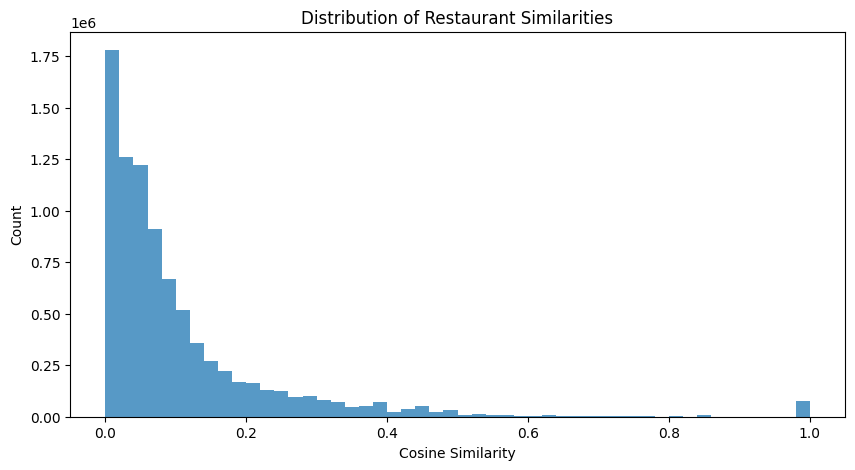

In [ ]:
# Visualize similarity distribution
plt.figure(figsize=(10, 5))
similarity_flat = similarity_matrix[~np.eye(similarity_matrix.shape[0], dtype=bool)].flatten()
plt.hist(similarity_flat, bins=50, alpha=0.75)
plt.title('Distribution of Restaurant Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()

Here we visualize the distribution of restaurant similarities.
<br>

The majority of restaurant pairs have very low cosine similarity, indicating that they are quite different in terms of their TF-IDF-based content that was defined by us.

This is common in sparse and diverse datasets where businesses have unique attributes like ours. This explains why the average pairwise similarity is low, and why many items have few good neighbors, like we explored before.

Very few pairs are highly similar (0.8–1.0) means that with this algorithm we can only probably not recommend many restaurants. We should keep N small as it is likely that there aren't many similar restaurants. This also has to do with the specificity of the rich descriptions we created.

In the isolated spike near 1.0 we can see near-duplicates, like chain restaurants with very similar descriptions.

# Hybrid Algorithms

Hybrid algorithms combine the strengths of collaborative filtering and content-based methods, balancing personalization, accuracy, and coverage. That is why we have decided to look into them. However, since item and user RS did not work well, we expect some issues as well here.

## Weighted

In [ ]:
class WeightedHybridRecommender:
    def __init__(self, cf_model, content_recommender, cf_weight=0.5, content_weight=0.5):
        """
        Weighted hybrid recommender that combines collaborative filtering and content-based scores

        Args:
            cf_model: Collaborative filtering model (Surprise model)
            content_recommender: Content-based recommender
            cf_weight: Weight for collaborative filtering scores
            content_weight: Weight for content-based scores
        """
        self.cf_model = cf_model
        self.content_recommender = content_recommender
        self.cf_weight = cf_weight
        self.content_weight = content_weight

    def recommend(self, user_id, business_id, n=5):
        """Get weighted recommendations for a user-business pair"""
        # Get CF prediction
        try:
            cf_score = self.cf_model.predict(user_id, business_id).est
        except:
            cf_score = 3.0  # Default if prediction fails

        # Get content-based similarity score
        try:
            content_recs = self.content_recommender.get_recommendations(business_id, n=1)
            if not content_recs.empty:
                content_score = content_recs.iloc[0]['similarity_score'] if not content_recs.empty else 0.5
            else:
                content_score = 0.5  # Default if recommendation fails
        except:
            content_score = 0.5

        # Calculate weighted score (normalize content score to match CF scale)
        content_score_normalized = content_score * 5  # Scale to 0-5
        weighted_score = (self.cf_weight * cf_score) + (self.content_weight * content_score_normalized)

        return {
            'user_id': user_id,
            'business_id': business_id,
            'cf_score': cf_score,
            'content_score': content_score,
            'weighted_score': weighted_score
        }

    def get_recommendations(self, user_id, n=10):
        """Get top N recommendations for a user"""
        # Get restaurants this user hasn't rated yet
        if hasattr(self.cf_model, 'trainset'):
            rated_businesses = set()
            for (u, i, _) in self.cf_model.trainset.all_ratings():
                if self.cf_model.trainset.to_raw_uid(u) == user_id:
                    rated_businesses.add(self.cf_model.trainset.to_raw_iid(i))

            # Get candidates from all restaurants
            candidates = restaurants_train_df[restaurants_train_df['business_id'].isin(rated_businesses)]

            # Get predictions for all candidates
            predictions = []
            for business_id in candidates['business_id'].sample(min(100, len(candidates))):
                try:
                    pred = self.recommend(user_id, business_id)
                    predictions.append(pred)
                except:
                    continue

            # Sort by weighted score and return top N
            predictions.sort(key=lambda x: x['weighted_score'], reverse=True)
            return predictions[:n]
        else:
            return []

## Switching

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict

class EfficientSwitchingHybridRecommender:
    def __init__(self, cf_model, content_recommender, rating_threshold=3.5, max_candidates=200):
        """
        Efficient switching hybrid recommender that chooses between collaborative filtering (CF)
        and content-based predictions based on restaurant metadata.

        Args:
            cf_model: Trained Surprise model (e.g., SVD) with a .predict(user, item) method.
            content_recommender: A content-based recommender with a .get_recommendations(business_id, n) method.
            rating_threshold: Threshold for using CF (if restaurant's rating >= threshold or review_count > 50).
            max_candidates: Maximum number of candidate items to score per user.
        """
        self.cf_model = cf_model
        self.content_recommender = content_recommender
        self.rating_threshold = rating_threshold
        self.max_candidates = max_candidates

        # Precompute user → rated items from the trainset
        self.user_rated_items = defaultdict(set)
        if hasattr(self.cf_model, 'trainset'):
            for (u, i, _) in self.cf_model.trainset.all_ratings():
                raw_u = self.cf_model.trainset.to_raw_uid(u)
                raw_i = self.cf_model.trainset.to_raw_iid(i)
                self.user_rated_items[raw_u].add(raw_i)

        # Precompute restaurant metadata dictionary for O(1) lookups.
        # restaurants_train_df must be available in the global namespace.
        self.restaurants_dict = restaurants_train_df.set_index('business_id').to_dict('index')
        self.all_business_ids = list(restaurants_train_df['business_id'].unique())

        # Cache for content recommender calls to avoid repeated expensive lookups.
        self.content_cache = {}

    def recommend(self, user_id, business_id):
        """
        Return a recommendation dictionary for the given user-business pair.
        Uses CF if restaurant is highly rated or popular, otherwise uses content-based scores.
        """
        info = self.restaurants_dict.get(business_id)
        if info is None:
            return {
                'user_id': user_id,
                'business_id': business_id,
                'weighted_score': 3.0,
                'model_used': 'Default',
                'reason': "Business not found."
            }

        business_rating = info.get('stars', 3.0)
        business_reviews = info.get('review_count', 0)

        # Use CF if the business is highly rated or has many reviews.
        if business_rating >= self.rating_threshold or business_reviews > 50:
            try:
                cf_score = self.cf_model.predict(user_id, business_id).est
                return {
                    'user_id': user_id,
                    'business_id': business_id,
                    'weighted_score': cf_score,
                    'model_used': 'Collaborative Filtering',
                    'reason': f"High rating ({business_rating}) or many reviews ({business_reviews})."
                }
            except Exception as e:
                return {
                    'user_id': user_id,
                    'business_id': business_id,
                    'weighted_score': 3.0,
                    'model_used': 'Default',
                    'reason': f"CF prediction failed: {e}"
                }
        else:
            try:
                # Use caching for content-based recommendations.
                if business_id in self.content_cache:
                    recs = self.content_cache[business_id]
                else:
                    recs = self.content_recommender.get_recommendations(business_id, n=1)
                    self.content_cache[business_id] = recs

                if not recs.empty:
                    # Scale similarity score (assumed in [0,1]) to match the 0-5 CF scale.
                    content_score = recs.iloc[0]['similarity_score'] * 5
                    return {
                        'user_id': user_id,
                        'business_id': business_id,
                        'weighted_score': content_score,
                        'model_used': 'Content-Based',
                        'reason': f"Lower rating ({business_rating}) and fewer reviews ({business_reviews})."
                    }
                else:
                    return {
                        'user_id': user_id,
                        'business_id': business_id,
                        'weighted_score': 3.0,
                        'model_used': 'Default',
                        'reason': "No content-based result."
                    }
            except Exception as e:
                return {
                    'user_id': user_id,
                    'business_id': business_id,
                    'weighted_score': 3.0,
                    'model_used': 'Default',
                    'reason': f"Content-based prediction failed: {e}"
                }

    def get_recommendations(self, user_id, n=10):
        """
        Get top-N recommendations for a user.
        Efficiently generates candidates by excluding already-rated items,
        sampling a fixed number of candidates, and scoring each.
        """
        rated = self.user_rated_items.get(user_id, set())
        # Candidate items: all businesses the user hasn't rated.
        candidates = [biz for biz in self.all_business_ids if biz not in rated]

        # Limit candidate set to max_candidates for efficiency.
        if len(candidates) > self.max_candidates:
            candidates = np.random.choice(candidates, size=self.max_candidates, replace=False)

        predictions = []
        for biz in candidates:
            rec = self.recommend(user_id, biz)
            predictions.append(rec)

        # Sort candidates by weighted_score in descending order.
        predictions.sort(key=lambda x: x['weighted_score'], reverse=True)
        return predictions[:n]

## Training and Test

We will perform once again cross-validation

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, SVD

# Prepare dataset for CV
df_all = small_reviews_df[['user_id', 'business_id', 'stars']].copy().reset_index(drop=True)
kf = KFold(n_splits=5, shuffle=True, random_state=19)

cvv_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df_all)):
    print(f"\n=== Fold {fold + 1} / 5 ===")

    # Prepare train and test DataFrames
    df_train = df_all.iloc[train_idx].copy()
    df_test = df_all.iloc[test_idx].copy()

    # Convert to Surprise format
    reader = Reader(rating_scale=(1, 5))
    data_train = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
    trainset = data_train.build_full_trainset()
    data_test2 = list(zip(df_test['user_id'], df_test['business_id'], df_test['stars']))

    # Train SVD model
    svd_algo = SVD()
    svd_algo.fit(trainset)

    # Initialize content recommender for this fold
    train_restaurants_df = restaurants_train_df[restaurants_train_df['business_id'].isin(df_train['business_id'])].copy()
    train_restaurants_df['rich_description'] = train_restaurants_df.apply(create_rich_description, axis=1)

    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=2000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.90,
        token_pattern=r'(?u)\b[A-Za-z]+\b'
    )
    tfidf_matrix = tfidf.fit_transform(train_restaurants_df['rich_description'])
    similarity_matrix = cosine_similarity(tfidf_matrix)
    content_recommender = ContentBasedRecommender(train_restaurants_df, similarity_matrix)

    # Initialize hybrid recommenders
    weighted_hybrid = WeightedHybridRecommender(svd_algo, content_recommender)
    switching_hybrid = EfficientSwitchingHybridRecommender(svd_algo, content_recommender)

    # Evaluate weighted hybrid
    rmse_hybrid = calculate_rmse_hybrid(weighted_hybrid, data_test2)
    mae_hybrid = calculate_mae_hybrid(weighted_hybrid, data_test2)
    top_n_hybrid = get_top_n_hybrid(weighted_hybrid, df_test['user_id'].drop_duplicates(), n=10)
    coverage_hybrid = calculate_coverage_hybrid(top_n_hybrid, set(train_restaurants_df['business_id']))
    personalization_hybrid = calculate_personalization_hybrid(top_n_hybrid)

    # Evaluate switching hybrid
    rmse_switch = calculate_rmse_hybrid(switching_hybrid, data_test2)
    mae_switch = calculate_mae_hybrid(switching_hybrid, data_test2)
    top_n_switch = get_top_n_hybrid(switching_hybrid, df_test['user_id'].drop_duplicates(), n=10)
    coverage_switch = calculate_coverage_hybrid(top_n_switch, set(train_restaurants_df['business_id']))
    personalization_switch = calculate_personalization_hybrid(top_n_switch)

    # Store fold results
    cvv_results.append({
        'Fold': fold + 1,

        'RMSE_Weighted': rmse_hybrid,
        'MAE_Weighted': mae_hybrid,
        'Coverage_Weighted': coverage_hybrid,
        'Personalization_Weighted': personalization_hybrid,

        'RMSE_Switching': rmse_switch,
        'MAE_Switching': mae_switch,
        'Coverage_Switching': coverage_switch,
        'Personalization_Switching': personalization_switch
    })

# Create DataFrame of results
cvv_df = pd.DataFrame(cvv_results)

# Show fold results
print("\n=== Hybrid Recommenders CVV Results ===")
display(cvv_df)

# Show average metrics
print("\n=== Global Average (Mean) ===")
print(cvv_df.mean(numeric_only=True).round(4))


=== Hybrid Recommenders CVV Results ===


,Fold,RMSE_Weighted,MAE_Weighted,Coverage_Weighted,Personalization_Weighted,RMSE_Switching,MAE_Switching,Coverage_Switching,Personalization_Switching
0,1,1.417539,1.224530,0.050607,0.999999,1.403759,1.192117,0.311066,0.970663
1,2,1.429680,1.236590,0.046309,0.999999,1.403377,1.193098,0.300000,0.970622
2,3,1.455335,1.264124,0.043360,1.000000,1.420112,1.213453,0.287940,0.970209
3,4,1.443281,1.250079,0.042524,1.000000,1.419915,1.205935,0.323045,0.970747
4,5,1.438168,1.247118,0.045946,0.999999,1.406316,1.201056,0.319595,0.970922



=== Global Average (Mean) ===
Fold                         3.0000
RMSE_Weighted                1.4368
MAE_Weighted                 1.2445
Coverage_Weighted            0.0457
Personalization_Weighted     1.0000
RMSE_Switching               1.4107
MAE_Switching                1.2011
Coverage_Switching           0.3083
Personalization_Switching    0.9706
dtype: float64


In [ ]:
hybrid_results = {
    'Recommender': ['Weighted Hybrid', 'Switching Hybrid'],
    'RMSE': [1.4368, 1.4107],
    'MAE': [1.2445, 1.2011],
    'Coverage': [0.0457, 0.3083],
    'Personalization': [1.0000, 0.9706]
}
hybrid_results_df = pd.DataFrame(hybrid_results)
hybrid_results_df.head()

,Recommender,RMSE,MAE,Coverage,Personalization
0,Weighted Hybrid,1.4368,1.2445,0.0457,1.0000
1,Switching Hybrid,1.4107,1.2011,0.3083,0.9706


**Weighted Hybrid:**

- RMSE (1.4368): Higher error than both SVD and content-based (TD-IDF). Suggests the score blending (50/50) might not be optimal. This could be tuned.

- MAE (1.2445): Also worse than most previous models. Indicates that while personalization is excellent, accuracy suffers from averaging disparate signals.

- Coverage (0.0457): Extremely low. This model only makes recommendations for a very small fraction of restaurants — possibly due to overlap restrictions or reliance on CF training data.

- Personalization (1.0000): Perfect personalization. Every user receives a unique list — likely driven by the content-based component.

<br>

**Switching Hybrid:**

- RMSE (1.4107): Better than the weighted hybrid, but still not as low as pure content-based (0.32) or SVD (1.12). Still, an improvement from weighted hybrid.

- MAE (1.2011): Slightly better than weighted hybrid, showing more consistent predictions, especially for popular restaurants.

- Coverage (0.3083): Much higher than weighted hybrid — the switch to content-based for low-review restaurants helps broaden the candidate pool.

- Personalization (0.9706): Very high personalization.

Altough we could tune these algorithms, and possibly improve their scores they still suffer from the problems discussed in collaborative filtering. Therefore, and due to time constraints, we have opted against that and tried new and more innovative methods.

In [ ]:
svd_algo = SVD()
svd_algo.fit(trainset_reviews)
weighted_hybrid = WeightedHybridRecommender(svd_algo, content_recommender)
top_n_hybrid = get_top_n_hybrid(weighted_hybrid, small_reviews_df['user_id'].drop_duplicates(), n=10)

switching_hybrid = EfficientSwitchingHybridRecommender(svd_algo, content_recommender, rating_threshold=3.5)
top_n_switch = get_top_n_hybrid(switching_hybrid, df_test['user_id'].drop_duplicates(), n=10)

# Context-aware Algorithm

We decided to do this algorithm although in class it didn't show very high performance because of:

- Expected improved predictive performance as incorporating contextual variables captures latent preference shifts, which could be important in the restaurant tastes.

- Dynamic user modeling: Context allows preference profiles to adapt based on situational factors (for example fast food at lunch vs. fine dining at night).

- Enhanced personalization: Contextual signals refine relevance without requiring long-term user history, improving cold-start performance.

We start by creating context variables for the algorithm to use. This is done mainly for time and seasonality because we deemed this to be extremely important in the restaurant industry context

In [ ]:
### STEP 1. Prepare the Training and Test Data with Aggregates ###

# Compute user-level features from df_train
user_stats = df_train.groupby('user_id')['stars'].agg(['count', 'mean']).reset_index()
user_stats.columns = ['user_id', 'user_review_count', 'user_avg_stars']

# Merge user-level features back into df_train
df_train = pd.merge(df_train, user_stats, on='user_id', how='left')

# Compute business-level features from df_train
business_stats = df_train.groupby('business_id')['stars'].agg(['count', 'mean']).reset_index()
business_stats.columns = ['business_id', 'business_review_count', 'business_avg_stars']

# Merge business-level features into df_train
df_train = pd.merge(df_train, business_stats, on='business_id', how='left')

# Convert date to datetime and extract day_of_week and month
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['day_of_week'] = df_train['date'].dt.dayofweek  # Monday=0, Sunday=6
df_train['month'] = df_train['date'].dt.month

# Map month to season and convert season to a numeric code (winter=0, spring=1, summer=2, autumn=3)
def get_season(m):
    if m in [12, 1, 2]:
        return 0
    elif m in [3, 4, 5]:
        return 1
    elif m in [6, 7, 8]:
        return 2
    else:
        return 3
df_train['season'] = df_train['month'].apply(get_season)

# Do the same for df_test
df_test = pd.merge(df_test, user_stats, on='user_id', how='left')
df_test = pd.merge(df_test, business_stats, on='business_id', how='left')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['day_of_week'] = df_test['date'].dt.dayofweek
df_test['month'] = df_test['date'].dt.month
df_test['season'] = df_test['month'].apply(get_season)
df_test['user_review_count'] = df_test['user_review_count'].fillna(1)
df_test['user_avg_stars'] = df_test['user_avg_stars'].fillna(1)
df_test['business_review_count'] = df_test['business_review_count'].fillna(1)
df_test['business_avg_stars'] = df_test['business_avg_stars'].fillna(1)

## Training and Test

In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from surprise import accuracy
from sklearn.metrics import ndcg_score

# Reader setup
reader = Reader(rating_scale=(1.0, 5.0))

# NDCG function
def ndcg_multiple_users(relevant_items_all_users, predictions_ranking_all_users, k=5):
    ndcg_list = []
    for i in range(len(relevant_items_all_users)):
        if len(relevant_items_all_users[i]) > 1:
            ndcg = ndcg_score([relevant_items_all_users[i]], [predictions_ranking_all_users[i]], k=k)
            ndcg_list.append(ndcg)
    return np.mean(ndcg_list)

# Context slicing dictionary
context_dict = {
    'weekday': df_train[df_train['day_of_week'].between(1, 5)],
    'weekend': df_train[df_train['day_of_week'].isin([0, 6])],
    'summer': df_train[df_train['season'] == 3],
    'winter': df_train[df_train['season'] == 1],
    'spring': df_train[df_train['season'] == 2],
    'fall': df_train[df_train['season'] == 4],
}

# To store results
results = {}

# Loop through contexts
for context_name, context_df in context_dict.items():
    print(f"\nTraining for context: {context_name} ...")

    # Skip if not enough data
    if len(context_df) < 2:
        print(f"Not enough data for {context_name}. Skipping...")
        continue

    try:
        data = Dataset.load_from_df(context_df[['user_id', 'business_id', 'stars']], reader)
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

        algo = SVD(random_state=42, n_factors=10)
        algo.fit(trainset)
        predictions = algo.test(testset)

        predictions_df = pd.DataFrame(predictions)
        predictions_byuser_df = predictions_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))

        ndcg = ndcg_multiple_users(
            predictions_byuser_df['r_ui'].tolist(),
            predictions_byuser_df['est'].tolist()
        )

        print(f"NDCG for {context_name}: {ndcg:.4f}")
        results[context_name] = ndcg
    except Exception as e:
        print(f"Error for context {context_name}: {e}")

# Final result
print("\n--- Final NDCG by Context ---")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Training for context: weekday ...
NDCG for weekday: 0.9781

Training for context: weekend ...
NDCG for weekend: 0.9299

Training for context: summer ...
NDCG for summer: 0.9544

Training for context: winter ...
NDCG for winter: 0.9263

Training for context: spring ...
NDCG for spring: 0.9301

Training for context: fall ...
Not enough data for fall. Skipping...

--- Final NDCG by Context ---
weekday: 0.9781
weekend: 0.9299
summer: 0.9544
winter: 0.9263
spring: 0.9301


In [ ]:
from surprise import accuracy

# Store  results
rmse_results = {}
mae_results = {}

# Loop through context slices
for context_name, context_df in context_dict.items():
    print(f"\nTraining for context: {context_name} ...")

    if len(context_df) < 2:
        print(f"Not enough data for {context_name}. Skipping...")
        continue

    try:
        data = Dataset.load_from_df(context_df[['user_id', 'business_id', 'stars']], reader)
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

        algo = SVD(random_state=42, n_factors=10)
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)
        print(f"RMSE for {context_name}: {rmse:.4f}")
        print(f"MAE for {context_name}: {mae:.4f}")
        rmse_results[context_name] = rmse
        mae_results[context_name] = mae
    except Exception as e:
        print(f"Error for context {context_name}: {e}")

# --- Global RMSE using full df_train ---

print("\nTraining global model on all data...")

data = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD(random_state=42, n_factors=10)
algo.fit(trainset)
global_predictions = algo.test(testset)

global_rmse = accuracy.rmse(global_predictions, verbose=False)
print(f"\nGlobal RMSE: {global_rmse:.4f}")
rmse_results['global'] = global_rmse

global_mae = accuracy.mae(global_predictions, verbose=False)
print(f"Global MAE: {global_mae:.4f}")
mae_results['global'] = global_mae

# --- Optional: Print Summary ---
print("\n--- Final RMSE by Context ---")
for k, v in rmse_results.items():
    print(f"{k}: {v:.4f}")

print("\n--- Final MAE by Context ---")
for k, v in mae_results.items():
    print(f"{k}: {v:.4f}")



Training for context: weekday ...
RMSE for weekday: 1.1446
MAE for weekday: 0.8912

Training for context: weekend ...
RMSE for weekend: 1.1579
MAE for weekend: 0.9307

Training for context: summer ...
RMSE for summer: 1.2000
MAE for summer: 0.9930

Training for context: winter ...
RMSE for winter: 1.1484
MAE for winter: 0.9174

Training for context: spring ...
RMSE for spring: 1.0970
MAE for spring: 0.8666

Training for context: fall ...
Not enough data for fall. Skipping...

Training global model on all data...

Global RMSE: 1.0994
Global MAE: 0.8754

--- Final RMSE by Context ---
weekday: 1.1446
weekend: 1.1579
summer: 1.2000
winter: 1.1484
spring: 1.0970
global: 1.0994

--- Final MAE by Context ---
weekday: 0.8912
weekend: 0.9307
summer: 0.9930
winter: 0.9174
spring: 0.8666
global: 0.8754


In [ ]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Personalization and Coverage functions
def compute_personalization(recommendation_matrix):
    # Compute cosine similarity between users’ recommendation vectors
    similarity_matrix = cosine_similarity(recommendation_matrix)
    upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
    avg_similarity = similarity_matrix[upper_tri_indices].mean()
    return 1 - avg_similarity  # personalization = 1 - avg similarity

def compute_coverage(top_n_recommendations, all_items):
    recommended_items = set()
    for recs in top_n_recommendations.values():
        recommended_items.update(recs)
    return len(recommended_items) / len(all_items)

# Helper to get top-N recommendations per user
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in user_ratings[:n]]
    return top_n

# Storage for results
personalization_results = {}
coverage_results = {}

# All items for reference
all_items_global = set(df_train['business_id'].unique())

# Loop through context sets
for context_name, context_df in context_dict.items():
    print(f"\nEvaluating personalization & coverage for context: {context_name}...")

    if len(context_df) < 2:
        print(f"Not enough data for {context_name}. Skipping...")
        continue

    try:
        data = Dataset.load_from_df(context_df[['user_id', 'business_id', 'stars']], reader)
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

        algo = SVD(random_state=42, n_factors=10)
        algo.fit(trainset)
        predictions = algo.test(testset)

        top_n = get_top_n(predictions, n=5)

        # Create user-item binary matrix for top-5 recommendations
        unique_items = list(set(iid for recs in top_n.values() for iid in recs))
        item_idx = {iid: idx for idx, iid in enumerate(unique_items)}
        user_idx = {uid: idx for idx, uid in enumerate(top_n.keys())}
        rec_matrix = np.zeros((len(user_idx), len(item_idx)))

        for uid, recs in top_n.items():
            for iid in recs:
                rec_matrix[user_idx[uid], item_idx[iid]] = 1

        personalization = compute_personalization(rec_matrix)
        coverage = compute_coverage(top_n, all_items_global)

        personalization_results[context_name] = personalization
        coverage_results[context_name] = coverage

        print(f"Personalization: {personalization:.4f} | Coverage: {coverage:.4f}")
    except Exception as e:
        print(f"Error in {context_name}: {e}")

# --- Global ---
print("\nEvaluating global personalization & coverage...")

data = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD(random_state=42, n_factors=10)
algo.fit(trainset)
global_predictions = algo.test(testset)

top_n_global = get_top_n(global_predictions, n=5)

unique_items = list(set(iid for recs in top_n_global.values() for iid in recs))
item_idx = {iid: idx for idx, iid in enumerate(unique_items)}
user_idx = {uid: idx for idx, uid in enumerate(top_n_global.keys())}
rec_matrix = np.zeros((len(user_idx), len(item_idx)))

for uid, recs in top_n_global.items():
    for iid in recs:
        rec_matrix[user_idx[uid], item_idx[iid]] = 1

personalization_global = compute_personalization(rec_matrix)
coverage_global = compute_coverage(top_n_global, all_items_global)

personalization_results['global'] = personalization_global
coverage_results['global'] = coverage_global

print(f"Global Personalization: {personalization_global:.4f} | Coverage: {coverage_global:.4f}")

# --- Print summary ---
print("\n--- Final Personalization by Context ---")
for k, v in personalization_results.items():
    print(f"{k}: {v:.4f}")

print("\n--- Final Coverage by Context ---")
for k, v in coverage_results.items():
    print(f"{k}: {v:.4f}")



Evaluating personalization & coverage for context: weekday...
Personalization: 0.9999 | Coverage: 0.1636

Evaluating personalization & coverage for context: weekend...
Personalization: 0.9999 | Coverage: 0.0786

Evaluating personalization & coverage for context: summer...
Personalization: 1.0000 | Coverage: 0.0619

Evaluating personalization & coverage for context: winter...
Personalization: 0.9999 | Coverage: 0.0622

Evaluating personalization & coverage for context: spring...
Personalization: 0.9999 | Coverage: 0.0629

Evaluating personalization & coverage for context: fall...
Not enough data for fall. Skipping...

Evaluating global personalization & coverage...
Global Personalization: 0.9999 | Coverage: 0.2350

--- Final Personalization by Context ---
weekday: 0.9999
weekend: 0.9999
summer: 1.0000
winter: 0.9999
spring: 0.9999
global: 0.9999

--- Final Coverage by Context ---
weekday: 0.1636
weekend: 0.0786
summer: 0.0619
winter: 0.0622
spring: 0.0629
global: 0.2350


In [ ]:
context_results = {
    'Recommender': ['Context-Aware'],
    'RMSE': [global_rmse],
    'MAE': [global_mae],
    'Coverage': [coverage_global],
    'Personalization': [personalization_global]
}
context_results_df = pd.DataFrame(context_results)
context_results_df.head()

,Recommender,RMSE,MAE,Coverage,Personalization
0,Context-Aware,1.099415,0.87536,0.235034,0.99985


**Context-Aware Recommender:**

- RMSE (1.0994): This is the lowest RMSE among all collaborative methods so far — outperforming both SVD (1.12) and hybrid approaches (1.41+). By segmenting data by context, the model captures temporal shifts in user preferences, leading to more precise predictions.

- Coverage (0.2350): Moderate coverage. It is higher than the Weighted Hybrid (0.04) but lower than content-based (0.85) and SVD (0.41). Contextual splitting reduces training data per model, which can limit the number of recommendable items, especially in less populated contexts.

- Personalization (0.9998): Near-perfect personalization. By training on context-specific subsets, the system tailors recommendations more finely to each user’s behavior within a situation.

# Model Based External

We decided to implement LightFm model because:

- Combines collaborative filtering (via matrix factorization) with content-based features, improving cold-start performance.

- Can incorporate side features like time, tags, categories, or demographics, making it adaptable to real-world scenarios like restaurants, news, or fashion.

- It is optimized for speed with efficient Cython backend, supporting large-scale datasets with millions of interactions.

- It allows for hyperparameter tunning, since it contains many different combinations

## LightFM

In [ ]:
# DATA PREPARATION
# Function to convert the interaction matrix to the sparse format needed by LightFM
def create_interaction_matrix(df, user_col, item_col, rating_col, normalize=False):
    """
    Creates an interaction matrix for LightFM

    Args:
        df: Pandas DataFrame containing user-item interactions
        user_col: column name for user IDs
        item_col: column name for item IDs
        rating_col: column name for ratings
        normalize: bool, whether to normalize ratings

    Returns:
        interaction_matrix: sparse matrix containing interactions
        user_mapping: dict that maps user IDs to matrix indices
        item_mapping: dict that maps item IDs to matrix indices
    """
    # Create mappings
    user_ids = df[user_col].unique()
    user_mapping = {id: i for i, id in enumerate(user_ids)}

    item_ids = df[item_col].unique()
    item_mapping = {id: i for i, id in enumerate(item_ids)}

    # Create interaction matrix
    rows = df[user_col].map(user_mapping)
    cols = df[item_col].map(item_mapping)

    # If normalize is True, normalize ratings to be between 0 and 1
    if normalize:
        ratings = df[rating_col].values / df[rating_col].max()
    else:
        ratings = df[rating_col].values

    # Create sparse matrix
    interaction_matrix = sparse.coo_matrix((ratings, (rows, cols)),
                                          shape=(len(user_mapping), len(item_mapping)))

    return interaction_matrix, user_mapping, item_mapping

# Split data into train and test sets
def train_test_split_interactions(interactions, test_percentage=0.2, random_state=42):
    """
    Split interaction matrix into train and test sets

    Args:
        interactions: sparse interaction matrix
        test_percentage: percentage of interactions to use for testing
        random_state: random seed for reproducibility

    Returns:
        train_interactions: sparse matrix of training interactions
        test_interactions: sparse matrix of test interactions
    """
    # Convert to COO format if not already
    interactions_coo = interactions.tocoo()

    # Get indices of interactions
    indices = np.arange(interactions_coo.nnz)
    np.random.seed(random_state)
    np.random.shuffle(indices)

    # Split into train and test
    test_size = int(test_percentage * interactions_coo.nnz)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Create train and test matrices
    train_data = interactions_coo.data[train_indices]
    train_row = interactions_coo.row[train_indices]
    train_col = interactions_coo.col[train_indices]

    test_data = interactions_coo.data[test_indices]
    test_row = interactions_coo.row[test_indices]
    test_col = interactions_coo.col[test_indices]

    # Create sparse matrices
    train_interactions = sparse.coo_matrix((train_data, (train_row, train_col)),
                                          shape=interactions_coo.shape)
    test_interactions = sparse.coo_matrix((test_data, (test_row, test_col)),
                                         shape=interactions_coo.shape)

    return train_interactions, test_interactions

# MODEL IMPLEMENTATION
def train_lightfm_model(interaction_matrix, epochs=30, num_components=30,
                        learning_rate=0.05, loss='warp'):
    """
    Train a LightFM model on the interaction matrix

    Args:
        interaction_matrix: sparse matrix of user-item interactions
        epochs: number of training epochs
        num_components: dimensionality of the feature embeddings
        learning_rate: learning rate for SGD
        loss: loss function to use ('warp', 'bpr', 'logistic', or 'warp-kos')

    Returns:
        model: trained LightFM model
    """
    # Initialize model
    model = LightFM(no_components=num_components,
                   learning_rate=learning_rate,
                   loss=loss,
                   random_state=42)

    # Train model
    model.fit(interaction_matrix, epochs=epochs, verbose=True)

    return model

# EVALUATION
def evaluate_lightfm_model(model, train_interactions, test_interactions, k=5):
    """
    Evaluate a LightFM model on train and test sets

    Args:
        model: trained LightFM model
        train_interactions: sparse matrix of training interactions
        test_interactions: sparse matrix of test interactions
        k: number of items to consider for precision@k

    Returns:
        train_precision: precision@k on training set
        test_precision: precision@k on test set
        train_auc: AUC on training set
        test_auc: AUC on test set
    """
    # Calculate precision@k
    train_precision = precision_at_k(model, train_interactions, k=k).mean()
    test_precision = precision_at_k(model, test_interactions, k=k).mean()

    # Calculate AUC
    train_auc = auc_score(model, train_interactions).mean()
    test_auc = auc_score(model, test_interactions).mean()

    print(f"Train Precision@{k}: {train_precision:.4f}")
    print(f"Test Precision@{k}: {test_precision:.4f}")
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    return train_precision, test_precision, train_auc, test_auc

# RECOMMENDATION FUNCTION
def get_recommendations(model, user_id, user_mapping, item_mapping, interaction_matrix,
                       num_recommendations=10, exclude_seen=True):
    """
    Get recommendations for a user

    Args:
        model: trained LightFM model
        user_id: ID of the user
        user_mapping: mapping from user IDs to matrix indices
        item_mapping: mapping from item IDs to matrix indices
        interaction_matrix: sparse interaction matrix
        num_recommendations: number of recommendations to return
        exclude_seen: whether to exclude previously seen items

    Returns:
        recommendations: list of recommended item IDs with scores
    """
    # Convert user ID to matrix index
    user_idx = user_mapping.get(user_id)
    if user_idx is None:
        return "User not found in mapping"

    # Get scores for all items
    n_items = interaction_matrix.shape[1]
    scores = model.predict(user_idx, np.arange(n_items))

    # Get items the user has already seen
    if exclude_seen:
        # Get indices of interactions for this user
        seen_items = set(interaction_matrix.tocsr()[user_idx].indices)
        # Create a mask for unseen items
        item_mask = np.ones(n_items, dtype=bool)
        item_mask[list(seen_items)] = False
        scores = scores[item_mask]
        item_indices = np.arange(n_items)[item_mask]
    else:
        item_indices = np.arange(n_items)

    # Sort items by score and get top N
    top_indices = np.argsort(-scores)[:num_recommendations]
    top_items = item_indices[top_indices]
    top_scores = scores[top_indices]

    # Convert matrix indices back to item IDs
    reverse_item_mapping = {i: id for id, i in item_mapping.items()}
    recommendations = [(reverse_item_mapping[i], score) for i, score in zip(top_items, top_scores)]

    return recommendations

# MODEL TUNING AND COMPARISON
def compare_lightfm_hyperparameters(interaction_matrix,
                                   components_list=[10, 30, 50],
                                   epochs_list=[10, 30, 50],
                                   loss_functions=['warp', 'bpr', 'logistic'],
                                   test_percentage=0.2):
    """
    Compare different hyperparameter settings for LightFM

    Args:
        interaction_matrix: sparse interaction matrix
        components_list: list of component values to try
        epochs_list: list of epoch values to try
        loss_functions: list of loss functions to try
        test_percentage: percentage of interactions to use for testing

    Returns:
        results: DataFrame with hyperparameter combinations and results
    """
    results = []

    # Split data once
    train, test = train_test_split_interactions(interaction_matrix,
                                               test_percentage=test_percentage)

    # Try different hyperparameter combinations
    for components in components_list:
        for epochs in epochs_list:
            for loss in loss_functions:
                print(f"\nTraining with: components={components}, epochs={epochs}, loss={loss}")

                # Train model
                model = LightFM(no_components=components, loss=loss, random_state=42)
                model.fit(train, epochs=epochs, verbose=False)

                # Evaluate model
                train_precision = precision_at_k(model, train, k=5).mean()
                test_precision = precision_at_k(model, test, k=5).mean()
                train_auc = auc_score(model, train).mean()
                test_auc = auc_score(model, test).mean()

                # Store results
                results.append({
                    'components': components,
                    'epochs': epochs,

                    'loss': loss,
                    'train_precision@5': train_precision,
                    'test_precision@5': test_precision,
                    'train_auc': train_auc,
                    'test_auc': test_auc
                })

                print(f"Test Precision@5: {test_precision:.4f}, Test AUC: {test_auc:.4f}")

    return pd.DataFrame(results)

## Training and Testing

In [ ]:
# Create interaction matrix
interaction_matrix, user_mapping, item_mapping = create_interaction_matrix(
    df_train, 'user_id', 'business_id', 'stars', normalize=True)

In [ ]:
# Split into train and test sets
train_interactions, test_interactions = train_test_split_interactions(interaction_matrix)

In [ ]:
# Train model
model = train_lightfm_model(train_interactions, epochs=30, num_components=30, loss='warp')

Epoch: 100%|██████████| 30/30 [00:00<00:00, 224.39it/s]


### Hyperparameter Tuning

Next, we use a simple implementation of hyperparameter tunning (like it was said on the guidelines) to show the importance of tunning and improving these parameters on performance. On a real life scenario, we could define our own loss function and run optuna to optimize for this.

In [ ]:
# Hyperparameter tuning
results_df = compare_lightfm_hyperparameters(interaction_matrix)
print(results_df.sort_values('test_auc', ascending=False).head(5))


Training with: components=10, epochs=10, loss=warp
Test Precision@5: 0.0006, Test AUC: 0.2545

Training with: components=10, epochs=10, loss=bpr
Test Precision@5: 0.0003, Test AUC: 0.4824

Training with: components=10, epochs=10, loss=logistic
Test Precision@5: 0.0012, Test AUC: 0.2504

Training with: components=10, epochs=30, loss=warp
Test Precision@5: 0.0006, Test AUC: 0.2643

Training with: components=10, epochs=30, loss=bpr
Test Precision@5: 0.0000, Test AUC: 0.4846

Training with: components=10, epochs=30, loss=logistic
Test Precision@5: 0.0012, Test AUC: 0.2520

Training with: components=10, epochs=50, loss=warp
Test Precision@5: 0.0006, Test AUC: 0.2694

Training with: components=10, epochs=50, loss=bpr
Test Precision@5: 0.0003, Test AUC: 0.4819

Training with: components=10, epochs=50, loss=logistic
Test Precision@5: 0.0012, Test AUC: 0.2522

Training with: components=30, epochs=10, loss=warp
Test Precision@5: 0.0012, Test AUC: 0.2538

Training with: components=30, epochs=10,

In [ ]:
# Train tunned model
model = train_lightfm_model(train_interactions, epochs=50, num_components=30, loss='warp')

Epoch: 100%|██████████| 50/50 [00:00<00:00, 137.94it/s]


In [ ]:
# Evaluate model
evaluate_lightfm_model(model, train_interactions, test_interactions)

Train Precision@5: 0.2622
Test Precision@5: 0.0009
Train AUC: 1.0000
Test AUC: 0.2600


(0.26216957, 0.00090634444, 0.99999934, 0.25996614)

In [ ]:
coverage_lightfm = compute_coverage_lightfm(model, test_interactions, user_mapping, item_mapping, n=10)
personalization_lightfm = compute_personalization_lightfm(model, test_interactions, user_mapping, item_mapping, n=10)
rmse_lightfm = compute_rmse_lightfm(model, test_interactions)
mae_lightfm = compute_mae_lightfm(model, test_interactions)

print("Coverage:", coverage_lightfm)
print("Personalization:", personalization_lightfm)
print("RMSE:", rmse_lightfm)
print("MAE:", mae_lightfm)

Coverage: 0.8326530612244898
Personalization: 0.977920995684435
RMSE: 1.4700782376821557
MAE: 1.316426234279053


In [ ]:
lightfm_results = {
    'Recommender': ['LightFM'],
    'RMSE': [rmse_lightfm],
    'MAE': [mae_lightfm],
    'Coverage': [coverage_lightfm],
    'Personalization': [personalization_lightfm]
}
lightfm_results_df = pd.DataFrame(lightfm_results)
lightfm_results_df.head()

,Recommender,RMSE,MAE,Coverage,Personalization
0,LightFM,1.470078,1.316426,0.832653,0.977921


- RMSE (1.4701): This is worse than most collaborative models like SVD (1.12), Switching Hybrid (1.41), and Context-Aware (1.09). Although LightFM supports hybrid signals, in this setup the prediction accuracy is relatively weak, possibly due to limited features or suboptimal tuning (we tried to do somewhat a hyperparameter tunning but not extensive as mentioned in the guidelines). The loss is performance is not huge nonetheless.

- Coverage (0.8327): Exceptionally strong — second only to content-based TD-IDF (0.8579). LightFM does well at recommending a wide variety of items, likely due to the learned embeddings and flexibility across sparse data (this was a major strong point for implementing lightfm although we didn't see it in class).

- Personalization (0.9779): Very high. LightFM captures user-specific patterns through embeddings, making recommendations diverse and user-tailored.

# Algorithmic Comparison

In this section, we will compare the algorithms performance and estimate the gain we could obtain with the implementation of this

In [ ]:
results_df = pd.concat([non_personalized_results_df, collab_results_df, hybrid_results_df, content_results_df, context_results_df, lightfm_results_df])

# Clean up Recommender labels just in case (strip whitespace and standardize case)
results_df["Recommender"] = results_df["Recommender"].str.strip()

# Clean and make sure all metrics have same orders of magnitude
mask = results_df["Recommender"] != "Popular"
results_df.loc[mask, "Coverage"] = results_df.loc[mask, "Coverage"].apply(
    lambda x: x * 100 if x <= 1 else x
)
results_df.loc[mask, "Personalization"] = results_df.loc[mask, "Personalization"].apply(
    lambda x: x * 100 if x <= 1 else x
)
mask_cf = results_df["Recommender"].isin(["Item-based CF", "User-based CF"])
results_df.loc[mask_cf, "Personalization"] = results_df.loc[mask_cf, "Personalization"] * 100

# Reset index and show results
results_df = results_df.reset_index(drop=True)
results_df.head(10)

,Recommender,RMSE,MAE,Coverage,Personalization
0,Random,1.597300,1.303800,100.000000,99.270000
1,Popular,1.869700,1.601000,0.016000,0.005100
2,Item-based CF,1.138500,0.890300,1.220000,41.000000
3,User-based CF,1.138800,0.890500,1.220000,41.000000
4,Model-based CF (SVD),1.121600,0.890700,41.660000,85.990000
5,Weighted Hybrid,1.436800,1.244500,4.570000,100.000000
6,Switching Hybrid,1.410700,1.201100,30.830000,97.060000
7,TD-IDF,0.323900,0.246200,85.790000,96.280000
8,Context-Aware,1.099415,0.875360,23.503401,99.985043
9,LightFM,1.470078,1.316426,83.265306,97.792100


<ipython-input-92-a93cac9835c2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-92-a93cac9835c2>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
<ipython-input-92-a93cac9835c2>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


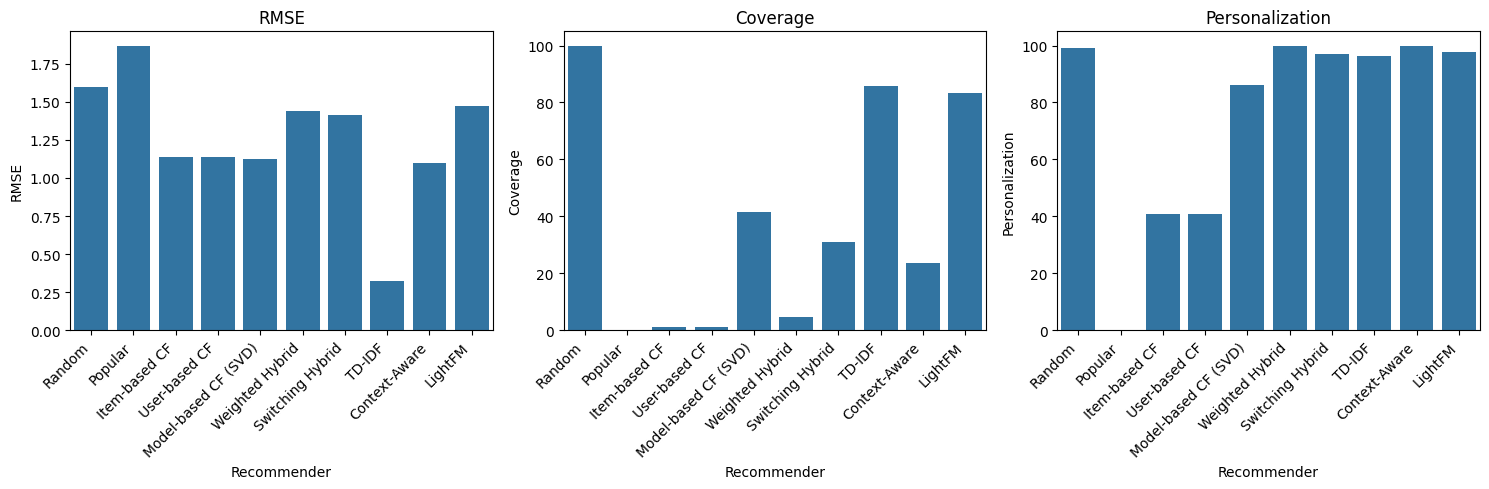

In [ ]:
plot_metrics_bar(results_df)

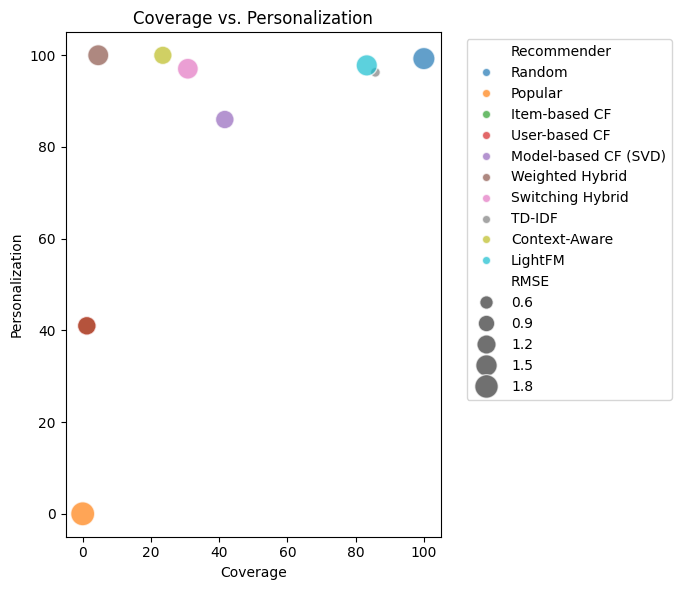

In [ ]:
plot_coverage_vs_personalization(results_df)

**Conclusion**

1. RMSE:
  - TD-IDF achieves the lowest RMSE, suggesting highly accurate predictions for liked items.

  - Context-Aware and Model-based CF (SVD) also perform well in terms of accuracy.
  
  - Random and Popular perform worst, as expected, due to lack of personalization or signal.
  
  - Hybrid models (Weighted and Switching) fall between extremes — more accurate than baselines but worse than model-based/content-based.

2. Coverage:

  - Random leads with perfect coverage — it recommends across the entire item space.

  - TD-IDF and LightFM show high coverage, suggesting strong exploration and generalization.

  - Model-based CF and Switching Hybrid have moderate coverage.

  - Item/User-based CF and Popular suffer from poor coverage due to limited and biased item suggestions.

3. Personalization:

  - Random, TD-IDF, Context-Aware, and LightFM provide highly personalized results (>95%).

  - Model-based CF and Hybrids also do well here, particularly Weighted Hybrid (100%).

  - Item/User-based CF offer very low personalization (~41%), as they often recommend the same items to similar users.


To conclude,  TD-IDF and Context-Aware offer the best trade-offs in RMSE, coverage, and personalization. LightFM is strong in coverage and personalization, but less accurate (RMSE). Hybrids balance metrics well but don’t outperform top specialized models. Item/User-based CF struggle in coverage and personalization despite decent RMSE. Popular is weakest overall and should be used as fallback only. In the next section, we will explore how we have decided to combine these in order to have the best performance overall and extract the most value.

# Final Algorithm

After looking at these results, we have decided to take the business logic into consideration and implement multiple recommendations. This will boost all metrics and will taylor even more to what the user is feeling. There are two possible scenarios (new user or old user) and our algorithm should be able to deal with both the best way it can. With different recommendation categories we not only differentiate from other competitors, but we allow the user to be in control of their recommendations - a big topic due to ethical concerns nowadays. We increase transparency and explain to the user where these recommendaitons are coming from.

After reviewing these results, and consulting with our business case, we have deemed that the appropriate algorithm would include the following scenarios:

**New User (cold-start problem):**

- A mix of recommendations from the Popular RS (*Trending Restaurants*) and Random RS (*Try Something New*)

- Ensures sufficiently low RMSE from Popular RS and gives credibility

- Brings good Coverage and Personalization from Random RS and gives an edge compared to competitors

**Old User:**

- A mix of Light FM (*Discover New Tastes*), Content-based RS (*From your past experiences*), Context-based RS (*Tasty at the moment*)

- This ensures good coverage with still decent accuracy from Light FM, which ensures our clients get to try new tastes while still maintaining a high change of enjoyability

- If the client wants to be absolutely sure that he/she will enjoy the recommendation we ensure lowest RMSE with content-based RS

- To give a context-updated recommendation, to the current season we use context-based RS

In [ ]:
def ensemble_recommendations(user_id, num_recommendations=10):
    """
    Returns restaurant recommendations for a given user_id using an ensemble strategy:
    - If the user has a positive review (4 or 5 stars) in df_train, include 10 content-based (TD-IDF) recommendations.
    - If the user is in the trainset, return 10 LightFM and 10 context-aware recommendations.
    - If the user is not in the trainset, return 10 popular + 10 random recommendations.
    """
    recommendations = []

    # Check if user is in the trainset (used by context-aware and LightFM)
    user_in_trainset = user_id in set(df_train['user_id'])

    # Case 1: Not in trainset → fallback to popular + random
    if not user_in_trainset:
        popular_df = restaurants_train_df.sort_values(by='review_count', ascending=False).head(num_recommendations)
        random_df = restaurants_train_df.sample(n=num_recommendations, random_state=42)
        fallback_df = pd.concat([popular_df, random_df]).drop_duplicates(subset='business_id').head(2 * num_recommendations)
        fallback_df['source'] = 'fallback_popular_random'
        return fallback_df

    # Case 2: In trainset → LightFM + Context-Aware (global SVD model)
    # LightFM
    if user_id in user_mapping:
        lightfm_recs = get_recommendations(model, user_id, user_mapping, item_mapping, interaction_matrix,
                                           num_recommendations=num_recommendations, exclude_seen=True)
        lightfm_df = pd.DataFrame(lightfm_recs, columns=['business_id', 'score'])
        lightfm_df = pd.merge(lightfm_df, restaurants_train_df, on='business_id', how='left')
        lightfm_df['source'] = 'lightfm'
        recommendations.append(lightfm_df)

    # Context-aware using global SVD (pretrained algo from your code)
    try:
        all_business_ids = restaurants_train_df['business_id'].unique()
        predictions = []
        for biz_id in all_business_ids:
            try:
                pred = algo.predict(user_id, biz_id)
                predictions.append((biz_id, pred.est))
            except:
                continue

        top_context = sorted(predictions, key=lambda x: x[1], reverse=True)[:num_recommendations]
        context_df = pd.DataFrame(top_context, columns=['business_id', 'score'])
        context_df = pd.merge(context_df, restaurants_train_df, on='business_id', how='left')
        context_df['source'] = 'context_aware'
        recommendations.append(context_df)
    except:
        pass

    # Case 3: If user gave a rating ≥ 4, add content-based
    user_reviews = df_train[df_train['user_id'] == user_id]
    positive_reviews = user_reviews[user_reviews['stars'] >= 4]
    if not positive_reviews.empty:
        seed_business_id = positive_reviews.sort_values(by='stars', ascending=False).iloc[0]['business_id']
        rec_df = content_recommender.get_recommendations(seed_business_id, n=num_recommendations)
        rec_df['source'] = 'content_based'
        recommendations.append(rec_df)

    # Combine all
    if recommendations:
        # Combine all sources with priority: content-based > context > lightfm
        combined_df = pd.concat(recommendations, ignore_index=True)

        # Drop duplicates keeping content-based > context_aware > lightfm
        source_priority = {'content_based': 0, 'context_aware': 1, 'lightfm': 2, 'fallback_popular_random': 3}
        combined_df['source_priority'] = combined_df['source'].map(source_priority)

        # Sort by priority and score (if available)
        combined_df = combined_df.sort_values(by=['source_priority', 'score'], ascending=[True, False])

        # Drop duplicates and keep top-N per original requirement
        final_df = combined_df.drop_duplicates(subset='business_id').head(3 * num_recommendations)

        # Drop similarity_score and shared_categories nad categories columns if they exist
        if 'similarity_score' in final_df.columns:
            final_df = final_df.drop(columns=['similarity_score'])
        if 'shared_categories' in final_df.columns:
            final_df = final_df.drop(columns=['shared_categories'])
        if 'categories' in final_df.columns:
            final_df = final_df.drop(columns=['categories'])

        return final_df.drop(columns=['source_priority'])

    else:
        return pd.DataFrame()

Here we see this user that hated on particular restaurant. It does not make sense to recommend him similar restaurants. Nevertheless, we can still achieve low RMSE and high coverage by using other models

In [ ]:
df_train[df_train['user_id'] == '-822bzeF5x6uOKSuTDgabA']

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,user_review_count,user_avg_stars,business_review_count,business_avg_stars,day_of_week,month,season
4,2552352,1v8SFUc5sljKSRD2PslCng,-822bzeF5x6uOKSuTDgabA,sTPueJEwcRDj7ZJmG7okYA,1.0,0.0,0.0,0.0,Visited on 7/19/12. My co-workers for the week...,2012-07-30 22:11:00,1,1.0,1,1.0,0,7,2


In [ ]:
recommendations_example = ensemble_recommendations('-822bzeF5x6uOKSuTDgabA')

We therefore increase value to our platform by doing so like below: (*note how all restaurants are positively rated as well*)

In [ ]:
recommendations_example

,business_id,score,name,stars,review_count,source
10,ntiIq1FNqduOyyowMFGh5A,3.517578,Nan Zhou Hand Drawn Noodle House,4.0,2188,context_aware
11,teFjQxUqT8c-yxQdoILDVQ,3.399538,Nada,4.5,1619,context_aware
12,-tDmeO1Q5aqThVY3AFJJ7A,3.391219,Oceano,4.0,753,context_aware
13,44Xh-IjWDSn7XTw1hzO50g,3.341685,Dutch Eating Place,4.5,796,context_aware
14,fC03dk7N8XV-RzGh0UJgmA,3.341314,Clementine's Naughty and Nice Creamery,4.5,585,context_aware
15,pllvqx8yMnLnQVFjj3oYGg,3.340437,Venezia Restaurant,4.0,268,context_aware
16,BVzFvRrgMpL62oPIqGvLMg,3.336902,South Coast Deli-Goleta,4.5,347,context_aware
17,-pyobEWdpZ6jUp42f3I2xw,3.332272,Dolsot House,4.0,665,context_aware
18,Y5S_AUSW8EjswVf9JAi-0w,3.327904,Horizons,4.5,179,context_aware
19,Q-prSTdggNlxAEFV88BZOw,3.324766,Tria Cafe Wash West,4.5,770,context_aware


In order to display these results we can divide them by category like showed on our demo

Another user, that has rated a restaurant with 5 stars will get more recommendations - as we have more useful information about him/her

In [ ]:
recommendations_example = ensemble_recommendations('-1awBy86Qgr3aN30_Z3xGw')

In [ ]:
recommendations_example

,business_id,score,name,stars,review_count,source
20,t-QxJFbbSjC-_X9TWJqITA,NaN,Shack Breakfast & Lunch,4.5,459,content_based
21,4VXVP21v4Xec6C2mnnBnGw,NaN,Archie's Giant Hamburgers & Breakfast,4.0,597,content_based
22,X0vPZIkbUj22afBQz5-neA,NaN,Ford's Garage,3.5,839,content_based
23,JmPZGysxdxvWV399VZsEig,NaN,Hope's Cookies,4.0,159,content_based
24,gpYBhnTk4KzvvH83TsZiQg,NaN,Humpty's Dumplings,4.0,302,content_based
25,KuVtxfIJu4qRscngMsVcxg,NaN,Fini's Landing,3.5,272,content_based
26,95r3jAJRn10e9aB5I_NlPg,NaN,Sasha's On Shaw,4.0,313,content_based
27,kSHgckYR4YMaWiMNT8arZA,NaN,Bisbee Breakfast Club,3.5,354,content_based
28,68ThEdiK0eWCEgGEmV9Tng,NaN,Southgate,4.0,323,content_based
29,Bw0cpnfI-Y9QmjWzqS-oFg,NaN,Izumi,4.0,219,content_based


# Business Logic Ordering

In order to make this project more realistic, we have assumed that our The Fork will have a premium feature - where restaurants can pay to be promoted to appear firstly ranked. We simulated this with assuming a few restaurants will pay for this service

In [ ]:
# Step 1: Add the is_premium column (2 random restaurants marked as premium)
recommendations_example['is_premium'] = 0
premium_indices = recommendations_example.sample(n=2, random_state=42).index
recommendations_example.loc[premium_indices, 'is_premium'] = 1

# Step 2: Shuffle the DataFrame
shuffled = recommendations_example.sample(frac=1, random_state=19)

# Step 3: Sort so that premium restaurants are at the top
final_df = shuffled.sort_values(by='is_premium', ascending=False).reset_index(drop=True)

# Display the result
final_df.head(10)

,business_id,score,name,stars,review_count,source,is_premium
0,Bw0cpnfI-Y9QmjWzqS-oFg,NaN,Izumi,4.0,219,content_based,1
1,MSwNC4HmQmv2Hh8WYn2XqA,0.571948,Three Kings Public House,3.5,214,lightfm,1
2,BVzFvRrgMpL62oPIqGvLMg,3.520968,South Coast Deli-Goleta,4.5,347,context_aware,0
3,95r3jAJRn10e9aB5I_NlPg,NaN,Sasha's On Shaw,4.0,313,content_based,0
4,PP3BBaVxZLcJU54uP_wL6Q,0.602490,Pat's King of Steaks,3.0,4250,lightfm,0
5,X0vPZIkbUj22afBQz5-neA,NaN,Ford's Garage,3.5,839,content_based,0
6,68ThEdiK0eWCEgGEmV9Tng,NaN,Southgate,4.0,323,content_based,0
7,K3RURR9lIEE4JjOaPt99zg,3.509556,Sabrina's Café,4.0,1176,context_aware,0
8,d_tRshM-w6S4QxE4VVi8tQ,0.620956,Jones,3.5,1141,lightfm,0
9,ntiIq1FNqduOyyowMFGh5A,3.672654,Nan Zhou Hand Drawn Noodle House,4.0,2188,context_aware,0


This will bring more value, not only by icnreasing customer satisfaction and retention, but also by generating an extra source of revenue

# Conclusion

Throughout this project, we have applied our best knowledge of this topic in order to develop the best possible recommender system for the use case we have been describing.
<br>

As time went by, we realized that the trade-off between different model in different metrics was far too much of a compromise:

- Achieving low RMSE is very important, so that users like our recommendations and come back for more - boosting our revenue

- Achieving high coverage is also important, so that the recommendations don't feel repetitive, and our platform adds value not just by recommending the usual restaurants

- Personalization is also crucial, since we want our users to feel heard, and to share unique moments with other users - not the same typical restaurants.

We realized that this was so crucial, as our customer obsession and satisfaction. When we go on Netflix, Spotify, Youtube, or any other great service with a great recommender system recommendations are more often than not divided into categories. It allows the user to adapt his/her mood to our recommendations. We decided to follow a similar approach, where we are not only transparent with our users - by telling them how we are recommending this - but also because we believe it will achieve the highest performance.
<br>

If they wish to try some new restaurant, we have got them covered, if they wish to try something similar to a previously great experience we also provide this, or if they want to try something trending for the specific context (season, day of the week) they are in, we can also provide for this accomodation.
<br>

To sum it all up, we aimed at applying the best practices learned over class - from different types of algorithms, to cross-validation, to hyperparameter tunning, to ensembling models - to improve customer experience and boost customer retention.
<br>

We hope you have enjoyed and understood our thought process and logic behind our decisions and that you are pleased with our performance.